# Companion code for the article "Dynamic Dimensioning of Frequency Containment Reserves: The Case of the Nordic Grid"

This notebook contains the code used to generate the results presented in the article "Dynamic Dimensioning of Frequency Containment Reserves: The Case of the Nordic Grid".


## Library import and auxiliary functions definition


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
from datetime import datetime, timedelta


def alt_K1(x_D, r_N, sigma, beta=0.8632915801291181):
    """Calculate K1 using alternative formula which uses normal CDF"""
    return (
        (sigma * np.sqrt(np.pi))
        / np.sqrt(beta * (r_N + x_D))
        * norm.cdf(-0.5 / (sigma / np.sqrt(2 * beta * (r_N + x_D))))
    )


def compute_K_integrals(x_D, r_N, sigma, beta=0.8632915801291181):
    """Compute K1, K2, K3 integrals"""

    def K1_integrand(y):
        return np.exp(-(y**2) * (beta * r_N + beta * x_D) / sigma**2)

    def K2_integrand(y):
        return np.exp(
            -(y**2) * (4 * beta * r_N - beta * x_D) / (4 * sigma**2)
            + y**3 * (5 * beta * x_D) / (3 * sigma**2)
        )

    def K3_integrand(y):
        return np.exp((20 * y**3 * beta * r_N) / (3 * sigma**2))

    K1, _ = quad(K1_integrand, -np.inf, -0.5, epsabs=1e-30, epsrel=1e-11)
    K2, _ = quad(K2_integrand, -0.5, -0.1, epsabs=1e-30, epsrel=1e-11)
    K3, _ = quad(K3_integrand, -0.1, 0.0, epsabs=1e-30, epsrel=1e-11)

    # this is just to check if the two formulas for K1 are equivalent
    if abs(K1 - alt_K1(x_D, r_N, sigma, beta)) > 1e-15:
        print(f"Discrepancy found! K1: {K1}, alt_K1: {alt_K1(x_D, r_N, sigma, beta)}")

    return K1, K2, K3


# Compute exact p2
def p2(x_D, r_N, sigma, beta=0.8632915801291181, logflag=False):
    """Compute exact p2 probability for a given x_D, r_N, sigma and beta"""
    K1, K2, K3 = compute_K_integrals(x_D, r_N, sigma, beta)

    if K1 == 0 or np.log10(K1) < -15:
        term2 = K2 * np.exp(-5 * beta * x_D / (48 * sigma**2))
        term3 = K3 * np.exp(-(31 * beta * x_D + beta * r_N) / (300 * sigma**2))
        if term2 == 0 or term3 == 0:
            if logflag:
                return -np.log10(
                    2 + 2 * K3 / K2 * np.exp(beta * (x_D - 4 * r_N) / (1200 * sigma**2))
                )
            else:
                return 1 / (
                    2 + 2 * K3 / K2 * np.exp(beta * (x_D - 4 * r_N) / (1200 * sigma**2))
                )
        if logflag:
            return np.log10(term2) - np.log10((2 * term2 + 2 * term3))
        else:
            return term2 / (2 * term2 + 2 * term3)
    else:
        term2 = K2 / K1 * np.exp(-5 * beta * x_D / (48 * sigma**2))
        term3 = K3 / K1 * np.exp(-(31 * beta * x_D + beta * r_N) / (300 * sigma**2))
        if logflag:
            return np.log10(term2 / (2 + 2 * term2 + 2 * term3))
        else:
            return term2 / (2 + 2 * term2 + 2 * term3)


def p2full(x_D, r_N, sigma, beta=0.8632915801291181):
    """Compute exact p2 terms explicitly, returns the log of all terms plus two alternative expressions for p2"""
    K1, K2, K3 = compute_K_integrals(x_D, r_N, sigma, beta)

    if K1 == 0 or np.log10(K1) < -15:
        term2 = K2 * np.exp(-5 * beta * x_D / (48 * sigma**2))
        term3 = K3 * np.exp(-(31 * beta * x_D + beta * r_N) / (300 * sigma**2))
        if term2 == 0 or term3 == 0:
            return (
                -np.inf,
                -np.inf,
                np.log10(K3),
                np.nan,  # no direct expressions available for this case
                -np.log10(
                    2 + 2 * K3 / K2 * np.exp(beta * (x_D - 4 * r_N) / (1200 * sigma**2))
                ),
            )
        else:
            return (
                -np.inf,
                np.log10(K2),
                np.log10(K3),
                np.nan,  # no direct expressions available for this case
                -np.log10(2 + 2 * term3 / term2),
            )
    else:
        term2 = K2 / K1 * np.exp(-5 * beta * x_D / (48 * sigma**2))
        term3 = K3 / K1 * np.exp(-(31 * beta * x_D + beta * r_N) / (300 * sigma**2))
        term2a = K2 * np.exp(-5 * beta * x_D / (48 * sigma**2))
        term3a = K3 * np.exp(-(31 * beta * x_D + beta * r_N) / (300 * sigma**2))

        return (
            np.log10(K1),
            np.log10(K2),
            np.log10(K3),
            np.log10(term2 / (2 + 2 * term2 + 2 * term3)),
            np.log10(term2a / (2 * term2a + 2 * term3a)),
        )

In [2]:
from scipy.optimize import fsolve, newton, bisect

x_D = 1.45
r_N = 0.6
sigma = 0.04037169
c2 = 0.0113346482


def equation_to_solve2_log(beta):
    return p2(x_D, r_N, sigma, beta, True) - np.log10(c2)


def equation_to_solve2(beta):
    return p2(x_D, r_N, sigma, beta, False) - c2


print("Using fsolve method")
beta2_solution = fsolve(equation_to_solve2, x0=1, xtol=1e-12)[0]
beta2_solution_log = fsolve(equation_to_solve2_log, x0=1, xtol=1e-12)[0]

print(
    "The value of beta2 that solves the equation for p2 is:     beta2    =",
    beta2_solution,
)
print(
    "The value of beta2 that solves the log-equation for p2 is: beta2_log=",
    beta2_solution_log,
)

# Compute rescaled p2 using the found beta2 values
print(f"p2_scaled(beta2) is:     {p2(x_D, r_N, sigma, beta=beta2_solution):.12f}")
print(f"p2_scaled(beta2_log) is: {p2(x_D, r_N, sigma, beta=beta2_solution_log):.12f}")
print(f"Actual value of p2 is:   {0.0113346482:.12f}\n\n")

print("Using Newton method")
beta2_solution = newton(equation_to_solve2, x0=1, tol=1e-15)
beta2_solution_log = newton(equation_to_solve2_log, x0=1, tol=1e-15)

print(
    "The value of beta2 that solves the equation for p2 is:     beta2    =",
    beta2_solution,
)
print(
    "The value of beta2 that solves the log-equation for p2 is: beta2_log=",
    beta2_solution_log,
)

# Compute rescaled p2 using the found beta2 values
print(f"p2_scaled(beta2) is:     {p2(x_D, r_N, sigma, beta=beta2_solution):.12f}")
print(f"p2_scaled(beta2_log) is: {p2(x_D, r_N, sigma, beta=beta2_solution_log):.12f}")
print(f"Actual value of p2 is:   {0.0113346482:.12f}\n\n")

print("Using bisection method")
beta2_solution = bisect(equation_to_solve2, a=0.5, b=1.5, xtol=1e-15)
beta2_solution_log = bisect(equation_to_solve2_log, a=0.5, b=1.5, xtol=1e-15)

print(
    "The value of beta2 that solves the equation for p2 is:     beta2    =",
    beta2_solution,
)
print(
    "The value of beta2 that solves the log-equation for p2 is: beta2_log=",
    beta2_solution_log,
)

# Compute rescaled p2 using the found beta2 values
print(f"p2_scaled(beta2) is:     {p2(x_D, r_N, sigma, beta=beta2_solution):.12f}")
print(f"p2_scaled(beta2_log) is: {p2(x_D, r_N, sigma, beta=beta2_solution_log):.12f}")
print(f"Actual value of p2 is:   {0.0113346482:.12f}")

Using fsolve method
The value of beta2 that solves the equation for p2 is:     beta2    = 0.8632915801291183
The value of beta2 that solves the log-equation for p2 is: beta2_log= 0.8632915801291119
p2_scaled(beta2) is:     0.011334648200
p2_scaled(beta2_log) is: 0.011334648200
Actual value of p2 is:   0.011334648200


Using Newton method
The value of beta2 that solves the equation for p2 is:     beta2    = 0.8632915801291192
The value of beta2 that solves the log-equation for p2 is: beta2_log= 0.8632915801291179
p2_scaled(beta2) is:     0.011334648200
p2_scaled(beta2_log) is: 0.011334648200
Actual value of p2 is:   0.011334648200


Using bisection method
The value of beta2 that solves the equation for p2 is:     beta2    = 0.8632915801291174
The value of beta2 that solves the log-equation for p2 is: beta2_log= 0.8632915801291139
p2_scaled(beta2) is:     0.011334648200
p2_scaled(beta2_log) is: 0.011334648200
Actual value of p2 is:   0.011334648200


/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1329057038.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  beta2_solution_log = fsolve(equation_to_solve2_log, x0=1, xtol=1e-12)[0]


## Create Figure 3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


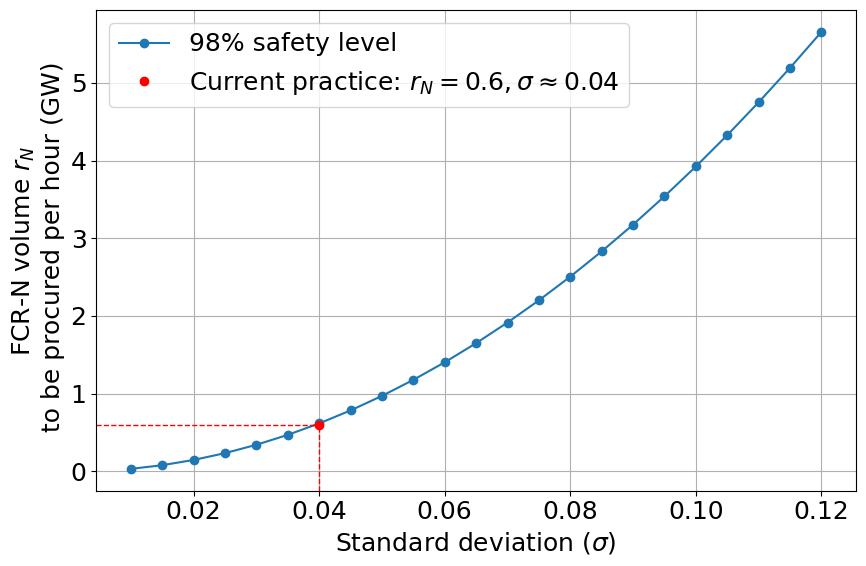

In [3]:
x_D = 1.45
sigmas = np.arange(0.01, 0.121, 0.005)
c2_values = [0.01]
beta = 0.8632915801291181

plt.rcParams["font.size"] = 18  # changes font size
plt.figure(figsize=(9, 6))

for c2 in c2_values:
    r_N_values = []
    for sigma in sigmas:

        def equation_to_solve(r_N):
            return p2(x_D, r_N, sigma, beta=beta, logflag=True) - np.log10(c2)

        r_N_solution = newton(equation_to_solve, x0=1, maxiter=100, x1=5, tol=1e-10)
        r_N_values.append(r_N_solution)

    plt.plot(sigmas, r_N_values, marker="o", label="98% safety level")

# Adding the red dot at x = 0.04 and y = 0.6
plt.plot(0.04, 0.6, "ro", label="Current practice: $r_N=0.6, \\sigma \\approx 0.04$")

# Adding horizontal dashed red line from x=0 to x=0.04 at y=0.6
plt.axhline(y=0.6, color="red", linestyle="--", linewidth=1, xmin=0, xmax=0.3)

# Adding vertical dashed red line from y=0 to y=0.6 at x=0.04
plt.axvline(x=0.04, color="red", linestyle="--", linewidth=1, ymin=0, ymax=0.13)

# Adding the legend
plt.legend(loc="best")

plt.xlabel("Standard deviation ($\\sigma$)")
plt.ylabel("FCR-N volume $r_N$ \n to be procured per hour (GW)")
plt.grid(True)
plt.tight_layout()
plt.savefig(
    "figures/FCR-N.eps",
    format="eps",
    dpi=400,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

### Code to create Figure 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


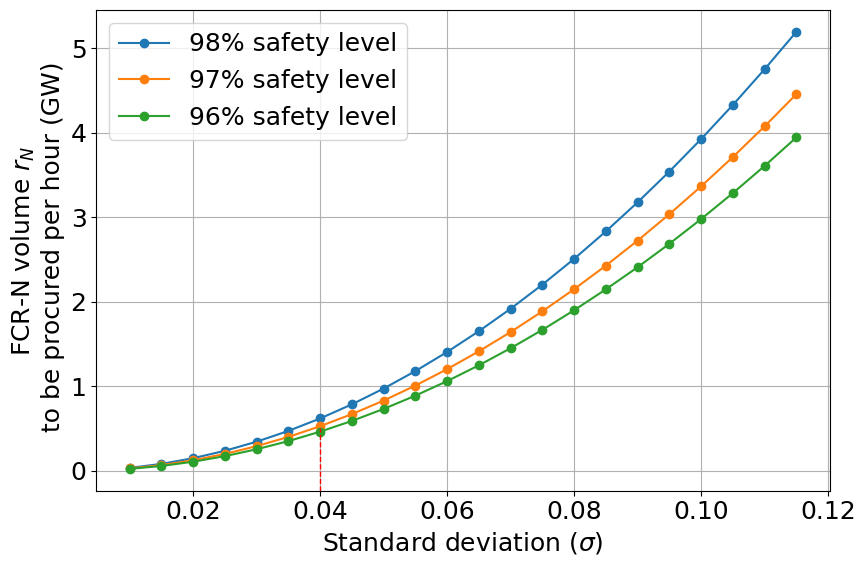

In [4]:
x_D = 1.45
sigmas = np.arange(0.01, 0.12, 0.005)
c2_values = [0.01, 0.015, 0.02]
beta = 0.8632915801291181

# Mapping c2 values to custom labels
custom_labels = {
    0.01: "98% safety level",
    0.015: "97% safety level",
    0.02: "96% safety level",
}

plt.rcParams["font.size"] = 18  # changes font size
plt.figure(figsize=(9, 6))
for c2 in c2_values:
    r_N_values = []
    for sigma in sigmas:

        def equation_to_solve(r_N):
            return p2(x_D, r_N, sigma, beta=beta, logflag=True) - np.log10(c2)

        r_N_solution = newton(equation_to_solve, x0=1, maxiter=100, x1=5, tol=1e-10)
        r_N_values.append(r_N_solution)

    # Use the custom label for the legend
    plt.plot(sigmas, r_N_values, marker="o", label=custom_labels[c2])

    # Adding vertical dashed red line from y=0 to y=0.6 at x=0.04
plt.axvline(x=0.04, color="red", linestyle="--", linewidth=1, ymin=0, ymax=0.13)

plt.xlabel("Standard deviation ($\\sigma$)")
plt.ylabel("FCR-N volume $r_N$ \n to be procured per hour (GW)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(
    "figures/SafetyLevels.eps",
    format="eps",
    dpi=400,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

## Case 0: baseline with constant $r_N^{(i)}=r_N = 0.6$ allocation


In [5]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6

# Step 2: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 3: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 4: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 5: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 6: Calculate `sigma_i` and use a constant value for `r_LinProv`
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = 0.6  # Use a constant value

# Step 7: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")
Eta_Lin = 5256 / B_Lin
print(f"Eta_Lin: {Eta_Lin}")

# Step 8: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 9: Save the results to a new CSV file
result_df.to_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/3136970736.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/3136970736.py:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 1a: Linear heuristic $r_N^{(i)}= \bar{r}_N \cdot \sigma_i/\bar{\sigma}$.


In [6]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6


# Step 2: Define heuristic function gLin
def gLin(sigma_i, sigma_bar, r_const):
    return r_const * sigma_i / sigma_bar


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gLin(row["sigma_i"], sigma_bar, r_const), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")
Eta_Lin = 5256 / B_Lin
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using linear heuristic - F_rec sigma bar 0.0333 beta 0.863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/2273926070.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/2273926070.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 1b: rescaled linear heuristic $r_N^{(i)}= \eta \cdot \bar{r}\_N \cdot \sigma_i/\bar{\sigma} $

The scalar $\eta$ is used to scaled down the allocation to match the total allocation of the baseline case.


In [7]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6


# Step 2: Define heuristic function gLin
def gLin(sigma_i, sigma_bar, r_const):
    return r_const * sigma_i / sigma_bar


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gLin(row["sigma_i"], sigma_bar, r_const), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")
Eta_Lin = 0.86
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using linear heuristic scaled DOWN - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/2526355932.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/2526355932.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 2: Generalized linear heuristic $r_N^{(i)}= a + b\cdot (\sigma_i/\bar{\sigma})$

The scalar parameters $a, b$ have been chosen such that $0.3 \leq a + b \cdot (\sigma_i/\bar{\sigma}) \leq 0.9$.


In [8]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6
a = 0.212566603779938
b = 0.216619245103255


# Step 2: Define heuristic function gGenLin
def gGenLin(sigma_i, sigma_bar, r_const, a, b):
    return a + b * sigma_i / sigma_bar


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gGenLin(row["sigma_i"], sigma_bar, r_const, a, b), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")
Eta_Lin = 5256 / B_Lin
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using GenLin heuristic - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/2206890538.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/2206890538.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 3: step heuristic with only three levels $r_N^{(i)}= \{0.3, 0.6, 0.9\}$


In [9]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6
xi_l = 0.75 * sigma_bar
xi_u = 1.25 * sigma_bar


# Step 2: Define heuristic function gStep
def gStep(sigma_i, sigma_bar, r_const, xi_l, xi_u):
    if sigma_i < xi_l:
        return 0.5 * r_const
    elif xi_l <= sigma_i <= xi_u:
        return r_const
    else:
        return 1.5 * r_const


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gStep(row["sigma_i"], sigma_bar, r_const, xi_l, xi_u), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")
Eta_Lin = 5256 / B_Lin
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using step heuristic - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1640906122.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1640906122.py:24: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 4: Capped linear heuristic with no rescaling


In [10]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6


# Step 2: Capped gLin to 0.6
def gLinCap(sigma_i, sigma_bar, r_const):
    if sigma_i < sigma_bar:
        return r_const * sigma_i / sigma_bar
    else:
        return r_const


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gLinCap(row["sigma_i"], sigma_bar, r_const), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")

# Setting eta to 1 to be able to see how much less r_N we get to and what that results in, in terms of p_2
Eta_Lin = 1
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using capped linear heuristic - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/198653206.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/198653206.py:20: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 5: Step heuristic with only two levels $r_N^{(i)}= \{0.3, 0.6\}$


In [11]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6
xi_l = 0.75 * sigma_bar
xi_u = 1.25 * sigma_bar


# Step 2: Capped gStep to 0.6
def gStepCap(sigma_i, sigma_bar, r_const, xi_l, xi_u):
    if sigma_i < xi_l:
        return 0.5 * r_const
    else:
        return r_const


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gStepCap(row["sigma_i"], sigma_bar, r_const, xi_l, xi_u), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")

# Setting eta to 1 to be able to see how much less r_N we get to and what that results in, in terms of p_2
Eta_Lin = 1
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using capped step heuristic - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1979436087.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1979436087.py:22: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 6: Generalized linear heuristic with $\eta=1.26$


In [12]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6
a = 0.212566603779938
b = 0.216619245103255


# Step 2: Define heuristic function gGenLin
def gGenLin(sigma_i, sigma_bar, r_const, a, b):
    return a + b * sigma_i / sigma_bar


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gGenLin(row["sigma_i"], sigma_bar, r_const, a, b), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")

# Setting eta to 1 to be able to see how much less r_N we get to and what that results in, in terms of p_2
Eta_Lin = 1.26
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using GenLin heuristic rescale 1p26 - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1155404991.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1155404991.py:19: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Case 7: Step heuristic with minimum 0.6 and $\eta=1$


In [13]:
# Step 1: Define parameters
x_D = 1.45
beta = 0.8632915801291181
sigma_bar = 0.03330250038960859
r_const = 0.6
zeta = 1.35 * sigma_bar
m = 2


# Step 2: Define heuristic function gStepFloor
def gStepFloor(sigma_i, sigma_bar, r_const, zeta, m):
    if sigma_i < zeta:
        return r_const
    else:
        return m * r_const


# Step 3: Create the hourly range
date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")

# Step 4: Read the input CSV file with explicit datetime parsing
input_df = pd.read_csv(
    "data/Std_Input_DefAdapt.csv",
    parse_dates=["DateHour"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H"),
)

# Step 5: Initialize the DataFrame for results
result_df = pd.DataFrame(date_range, columns=["Hour"])

# Step 6: Ensure the 'Hour' column has the same format as 'DateHour'
result_df["Hour"] = result_df["Hour"].dt.strftime("%Y-%m-%d %H")

# Step 7: Calculate `sigma_i`, `r_LinProv`, and other required columns
sigma_i_list = []
for hour in result_df["Hour"]:
    row = input_df[input_df["DateHour"] == hour]
    if not row.empty:
        sigma_i = row["Std F_rec"].values[0]
    else:
        print(f"Hour {hour} not found in input CSV. Using sigma_bar value.")
        sigma_i = sigma_bar
    sigma_i_list.append(sigma_i)

result_df["sigma_i"] = sigma_i_list
result_df["r_LinProv"] = result_df.apply(
    lambda row: gStepFloor(row["sigma_i"], sigma_bar, r_const, zeta, m), axis=1
)

# Step 8: Calculate `B_Lin` and `Eta_Lin`
B_Lin = result_df["r_LinProv"].sum()
print(f"B_Lin: {B_Lin}")
Eta_Lin = 1
print(f"Eta_Lin: {Eta_Lin}")

# Step 9: Compute `r_Lin` and `p2`
result_df["r_Lin"] = result_df["r_LinProv"] * Eta_Lin
Sum_r_Lin = result_df["r_Lin"].sum()
print(f"Sum_r_Lin: {Sum_r_Lin}")
result_df["p2"] = result_df.apply(
    lambda row: p2(x_D, row["r_Lin"], row["sigma_i"], beta, False), axis=1
)

# Step 10: Save the results to a CSV file
result_df.to_csv(
    "results/Calculating p2 using stepfloor heuristic m is 2 zeta is 1p35 - F_rec sigma bar 0p0333 beta 0p863.csv",
    index=False,
)

/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1502783192.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start="2022-12-01 00:00", end="2023-11-30 23:00", freq="H")
/var/folders/zb/k0pc77yj6c3gv6gr6jj41g1r0000gn/T/ipykernel_24233/1502783192.py:22: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  input_df = pd.read_csv(


Hour 2023-03-26 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 11 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 12 not found in input CSV. Using sigma_bar value.
Hour 2023-07-11 13 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 04 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 05 not found in input CSV. Using sigma_bar value.
Hour 2023-07-23 06 not found in input CSV. Using sigma_bar value.
Hour 2023-07-24 23 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 00 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 01 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 02 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 03 not found in input CSV. Using sigma_bar value.
Hour 2023-07-25 04 not found in input CSV. Using sigma_bar value.
Hour 2023-

## Generating figures and exporting tables


In [14]:
# Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_stepfloor = pd.read_csv(
    "results/Calculating p2 using stepfloor heuristic m is 2 zeta is 1p35 - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Step 1: Define constants
sigma_bar = 0.034390059907019994
xi_l = 0.75
xi_u = 1.25

# Step 2: Calculate the total sum of the 'p2' and 'r_Lin' column values for the 2 datasets
sum_p2_constant = np.nansum(df_constant["p2"])
sum_p2_stepfloor = np.nansum(df_stepfloor["p2"])
sum_rN_constant = np.nansum(df_constant["r_Lin"])
sum_rN_stepfloor = np.nansum(df_stepfloor["r_Lin"])

print(f"Total sum of 'p2' values (Constant): {sum_p2_constant}")
print(f"Total sum of 'p2' values (Stepfloor): {sum_p2_stepfloor}")
print(f"Total sum of 'r_Lin' values (Constant): {sum_rN_constant}")
print(f"Total sum of 'r_Lin' values (Stepfloor): {sum_rN_stepfloor}")

# Step 3: Divide rows into 4 groups based on 'sigma_i' values
sigma_i = df_constant[
    "sigma_i"
]  # Assuming 'sigma_i' is identical across all dataframes

group1 = df_constant[sigma_i <= xi_l * sigma_bar]
group2 = df_constant[(sigma_i > xi_l * sigma_bar) & (sigma_i <= sigma_bar)]
group3 = df_constant[(sigma_i > sigma_bar) & (sigma_i <= xi_u * sigma_bar)]
group4 = df_constant[sigma_i > xi_u * sigma_bar]

# Print the number of rows in each group
print(f"Group 1: {len(group1)} rows")
print(f"Group 2: {len(group2)} rows")
print(f"Group 3: {len(group3)} rows")
print(f"Group 4: {len(group4)} rows")

# Step 4: Calculate the sum of 'p2' and 'r_Lin' values for the 4 groups in each dataset
# Group sums for 'p2' (constant)
group1_sum_p2_constant = np.nansum(group1["p2"])
group2_sum_p2_constant = np.nansum(group2["p2"])
group3_sum_p2_constant = np.nansum(group3["p2"])
group4_sum_p2_constant = np.nansum(group4["p2"])

# Group sums for 'p2' (stepfloor)
group1_sum_p2_stepfloor = np.nansum(df_stepfloor.loc[group1.index, "p2"])
group2_sum_p2_stepfloor = np.nansum(df_stepfloor.loc[group2.index, "p2"])
group3_sum_p2_stepfloor = np.nansum(df_stepfloor.loc[group3.index, "p2"])
group4_sum_p2_stepfloor = np.nansum(df_stepfloor.loc[group4.index, "p2"])

# Group sums for 'r_Lin' (constant)
group1_sum_rN_constant = np.nansum(group1["r_Lin"])
group2_sum_rN_constant = np.nansum(group2["r_Lin"])
group3_sum_rN_constant = np.nansum(group3["r_Lin"])
group4_sum_rN_constant = np.nansum(group4["r_Lin"])

# Group sums for 'r_Lin' (stepfloor)
group1_sum_rN_stepfloor = np.nansum(df_stepfloor.loc[group1.index, "r_Lin"])
group2_sum_rN_stepfloor = np.nansum(df_stepfloor.loc[group2.index, "r_Lin"])
group3_sum_rN_stepfloor = np.nansum(df_stepfloor.loc[group3.index, "r_Lin"])
group4_sum_rN_stepfloor = np.nansum(df_stepfloor.loc[group4.index, "r_Lin"])


# Step 5: Calculate ratios for each group
def calculate_ratio(stepfloor_sum, constant_sum):
    return stepfloor_sum / constant_sum if constant_sum != 0 else np.nan


# Total ratios for 'p2' and 'r_Lin'
total_ratio_p2_stepfloor = calculate_ratio(sum_p2_stepfloor, sum_p2_constant)
total_ratio_rN_stepfloor = calculate_ratio(sum_rN_stepfloor, sum_rN_constant)

# Group ratios for 'p2'
group1_ratio_p2_stepfloor = calculate_ratio(
    group1_sum_p2_stepfloor, group1_sum_p2_constant
)
group2_ratio_p2_stepfloor = calculate_ratio(
    group2_sum_p2_stepfloor, group2_sum_p2_constant
)
group3_ratio_p2_stepfloor = calculate_ratio(
    group3_sum_p2_stepfloor, group3_sum_p2_constant
)
group4_ratio_p2_stepfloor = calculate_ratio(
    group4_sum_p2_stepfloor, group4_sum_p2_constant
)

# Group ratios for 'r_Lin'
group1_ratio_rN_stepfloor = calculate_ratio(
    group1_sum_rN_stepfloor, group1_sum_rN_constant
)
group2_ratio_rN_stepfloor = calculate_ratio(
    group2_sum_rN_stepfloor, group2_sum_rN_constant
)
group3_ratio_rN_stepfloor = calculate_ratio(
    group3_sum_rN_stepfloor, group3_sum_rN_constant
)
group4_ratio_rN_stepfloor = calculate_ratio(
    group4_sum_rN_stepfloor, group4_sum_rN_constant
)

# Step 6: Print ratios for each group and totals
print("\nGroup Sums (p2):")
print(f"Group 1 (p2) sum (Constant): {group1_sum_p2_constant}")
print(f"Group 1 (p2) sum (Stepfloor): {group1_sum_p2_stepfloor}")
print(f"Group 2 (p2) sum (Constant): {group2_sum_p2_constant}")
print(f"Group 2 (p2) sum (Stepfloor): {group2_sum_p2_stepfloor}")
print(f"Group 3 (p2) sum (Constant): {group3_sum_p2_constant}")
print(f"Group 3 (p2) sum (Stepfloor): {group3_sum_p2_stepfloor}")
print(f"Group 4 (p2) sum (Constant): {group4_sum_p2_constant}")
print(f"Group 4 (p2) sum (Stepfloor): {group4_sum_p2_stepfloor}")

print("\nGroup Sums (rN):")
print(f"Group 1 (rN) sum (Constant): {group1_sum_rN_constant}")
print(f"Group 1 (rN) sum (Stepfloor): {group1_sum_rN_stepfloor}")
print(f"Group 2 (rN) sum (Constant): {group2_sum_rN_constant}")
print(f"Group 2 (rN) sum (Stepfloor): {group2_sum_rN_stepfloor}")
print(f"Group 3 (rN) sum (Constant): {group3_sum_rN_constant}")
print(f"Group 3 (rN) sum (Stepfloor): {group3_sum_rN_stepfloor}")
print(f"Group 4 (rN) sum (Constant): {group4_sum_rN_constant}")
print(f"Group 4 (rN) sum (Stepfloor): {group4_sum_rN_stepfloor}")

print("\nGroup Ratios (p2):")
print(f"Group 1 (p2) ratio: {group1_ratio_p2_stepfloor}")
print(f"Group 2 (p2) ratio: {group2_ratio_p2_stepfloor}")
print(f"Group 3 (p2) ratio: {group3_ratio_p2_stepfloor}")
print(f"Group 4 (p2) ratio: {group4_ratio_p2_stepfloor}")

print("\nGroup Ratios (rN):")
print(f"Group 1 (rN) ratio: {group1_ratio_rN_stepfloor}")
print(f"Group 2 (rN) ratio: {group2_ratio_rN_stepfloor}")
print(f"Group 3 (rN) ratio: {group3_ratio_rN_stepfloor}")
print(f"Group 4 (rN) ratio: {group4_ratio_rN_stepfloor}")

print(f"\nTotal ratio (p2): {total_ratio_p2_stepfloor}")
print(f"Total ratio (rN): {total_ratio_rN_stepfloor}")

Total sum of 'p2' values (Constant): 56.41212700953699
Total sum of 'p2' values (Stepfloor): 36.159580990341695
Total sum of 'r_Lin' values (Constant): 5255.999999999999
Total sum of 'r_Lin' values (Stepfloor): 5696.999999999998
Group 1: 1312 rows
Group 2: 4268 rows
Group 3: 2218 rows
Group 4: 962 rows

Group Sums (p2):
Group 1 (p2) sum (Constant): 0.1736110355272287
Group 1 (p2) sum (Stepfloor): 0.17361103552722895
Group 2 (p2) sum (Constant): 7.478148699569362
Group 2 (p2) sum (Stepfloor): 7.4781486995693705
Group 3 (p2) sum (Constant): 18.05389887313328
Group 3 (p2) sum (Stepfloor): 18.0538988731333
Group 4 (p2) sum (Constant): 30.70646840130711
Group 4 (p2) sum (Stepfloor): 10.453922382111806

Group Sums (rN):
Group 1 (rN) sum (Constant): 787.2
Group 1 (rN) sum (Stepfloor): 787.1999999999998
Group 2 (rN) sum (Constant): 2560.8
Group 2 (rN) sum (Stepfloor): 2560.7999999999993
Group 3 (rN) sum (Constant): 1330.8000000000002
Group 3 (rN) sum (Stepfloor): 1330.8
Group 4 (rN) sum (Const

### Input for Figure 8 and Table 2


In [15]:
# Step 1: Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_scalelin = pd.read_csv(
    "results/Calculating p2 using linear heuristic scaled DOWN - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Step 2: Define constants
sigma_bar = 0.03330250038960859
xi_l = 0.75
xi_u = 1.25

# Step 3: Calculate the total sum of the 'p2' and 'r_Lin' column values for the 2 datasets
sum_p2_constant = np.nansum(df_constant["p2"])
sum_p2_scalelin = np.nansum(df_scalelin["p2"])

sum_rN_constant = np.nansum(df_constant["r_Lin"])
sum_rN_scalelin = np.nansum(df_scalelin["r_Lin"])

print(f"Step 3:")
print(f"Total sum of 'p2' values (Constant): {sum_p2_constant}")
print(f"Total sum of 'p2' values (ScaleLin): {sum_p2_scalelin}")
print(f"Total sum of 'r_Lin' values (Constant): {sum_rN_constant}")
print(f"Total sum of 'r_Lin' values (ScaleLin): {sum_rN_scalelin}")

# Step 4: Divide rows into 4 groups based on 'sigma_i' values
sigma_i = df_constant[
    "sigma_i"
]  # Assuming 'sigma_i' is identical across all dataframes

group1 = df_constant[sigma_i <= xi_l * sigma_bar]
group2 = df_constant[(sigma_i > xi_l * sigma_bar) & (sigma_i <= sigma_bar)]
group3 = df_constant[(sigma_i > sigma_bar) & (sigma_i <= xi_u * sigma_bar)]
group4 = df_constant[sigma_i > xi_u * sigma_bar]

# Print the number of rows in each group
print(f"\nStep 4:")
print(f"Group 1: {len(group1)} rows")
print(f"Group 2: {len(group2)} rows")
print(f"Group 3: {len(group3)} rows")
print(f"Group 4: {len(group4)} rows")

# Step 5: Calculate the sum of 'p2' and 'r_Lin' values for the 4 groups in each dataset
# Group sums for 'p2' and 'r_Lin' (constant)
group1_sum_constant_p2 = np.nansum(group1["p2"])
group2_sum_constant_p2 = np.nansum(group2["p2"])
group3_sum_constant_p2 = np.nansum(group3["p2"])
group4_sum_constant_p2 = np.nansum(group4["p2"])

group1_sum_constant_rN = np.nansum(group1["r_Lin"])
group2_sum_constant_rN = np.nansum(group2["r_Lin"])
group3_sum_constant_rN = np.nansum(group3["r_Lin"])
group4_sum_constant_rN = np.nansum(group4["r_Lin"])

# Group sums for 'p2' and 'r_Lin' (scalelin)
group1_sum_scalelin_p2 = np.nansum(df_scalelin.loc[group1.index, "p2"])
group2_sum_scalelin_p2 = np.nansum(df_scalelin.loc[group2.index, "p2"])
group3_sum_scalelin_p2 = np.nansum(df_scalelin.loc[group3.index, "p2"])
group4_sum_scalelin_p2 = np.nansum(df_scalelin.loc[group4.index, "p2"])

group1_sum_scalelin_rN = np.nansum(df_scalelin.loc[group1.index, "r_Lin"])
group2_sum_scalelin_rN = np.nansum(df_scalelin.loc[group2.index, "r_Lin"])
group3_sum_scalelin_rN = np.nansum(df_scalelin.loc[group3.index, "r_Lin"])
group4_sum_scalelin_rN = np.nansum(df_scalelin.loc[group4.index, "r_Lin"])

# Step 6: Print the group sums for each heuristic
print(f"\nStep 6: Group sums")
# Constant heuristic
print("\nConstant:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_constant_p2}")
print(f"    Group 2 sum: {group2_sum_constant_p2}")
print(f"    Group 3 sum: {group3_sum_constant_p2}")
print(f"    Group 4 sum: {group4_sum_constant_p2}")
constant_p2_total = (
    group1_sum_constant_p2
    + group2_sum_constant_p2
    + group3_sum_constant_p2
    + group4_sum_constant_p2
)
print(f"  Subtotal (p2): {constant_p2_total}")

# Directly copy values
print(f"{group1_sum_constant_p2},")
print(f"{group2_sum_constant_p2},")
print(f"{group3_sum_constant_p2},")
print(f"{group4_sum_constant_p2},")


print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_constant_rN}")
print(f"    Group 2 sum: {group2_sum_constant_rN}")
print(f"    Group 3 sum: {group3_sum_constant_rN}")
print(f"    Group 4 sum: {group4_sum_constant_rN}")
constant_rN_total = (
    group1_sum_constant_rN
    + group2_sum_constant_rN
    + group3_sum_constant_rN
    + group4_sum_constant_rN
)
print(f"  Subtotal (r_Lin): {constant_rN_total}")

# Scalelin heuristic
print("\nScaleLin:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_scalelin_p2}")
print(f"    Group 2 sum: {group2_sum_scalelin_p2}")
print(f"    Group 3 sum: {group3_sum_scalelin_p2}")
print(f"    Group 4 sum: {group4_sum_scalelin_p2}")
scalelin_p2_total = (
    group1_sum_scalelin_p2
    + group2_sum_scalelin_p2
    + group3_sum_scalelin_p2
    + group4_sum_scalelin_p2
)
print(f"  Subtotal (p2): {scalelin_p2_total}")
print(
    f"  Difference from Constant p2 subtotal: {scalelin_p2_total - constant_p2_total}"
)

# Directly copy values
print(f"{group1_sum_scalelin_p2},")
print(f"{group2_sum_scalelin_p2},")
print(f"{group3_sum_scalelin_p2},")
print(f"{group4_sum_scalelin_p2},")
print(f"{constant_p2_total - scalelin_p2_total}")


print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_scalelin_rN}")
print(f"    Group 2 sum: {group2_sum_scalelin_rN}")
print(f"    Group 3 sum: {group3_sum_scalelin_rN}")
print(f"    Group 4 sum: {group4_sum_scalelin_rN}")
scalelin_rN_total = (
    group1_sum_scalelin_rN
    + group2_sum_scalelin_rN
    + group3_sum_scalelin_rN
    + group4_sum_scalelin_rN
)
print(f"  Subtotal (r_Lin): {scalelin_rN_total}")
print(
    f"  Difference from Constant r_Lin subtotal: {scalelin_rN_total - constant_rN_total}"
)


# Step 7: Calculate ratios for each group
def calculate_ratio(scalelin_sum, constant_sum):
    return scalelin_sum / constant_sum - 1 if constant_sum != 0 else np.nan


def calculate_ratio_rN(scalelin_sum, constant_sum):
    return scalelin_sum / constant_sum - 1 if constant_sum != 0 else np.nan


# Total ratios
total_ratio_scalelin = calculate_ratio(sum_p2_scalelin, sum_p2_constant)

total_rN_ratio_scalelin = calculate_ratio_rN(sum_rN_scalelin, sum_rN_constant)

# Group ratios
group1_ratio_scalelin = calculate_ratio(group1_sum_scalelin_p2, group1_sum_constant_p2)
group1_rN_ratio_scalelin = calculate_ratio_rN(
    group1_sum_scalelin_rN, group1_sum_constant_rN
)

group2_ratio_scalelin = calculate_ratio(group2_sum_scalelin_p2, group2_sum_constant_p2)
group2_rN_ratio_scalelin = calculate_ratio_rN(
    group2_sum_scalelin_rN, group2_sum_constant_rN
)

group3_ratio_scalelin = calculate_ratio(group3_sum_scalelin_p2, group3_sum_constant_p2)
group3_rN_ratio_scalelin = calculate_ratio_rN(
    group3_sum_scalelin_rN, group3_sum_constant_rN
)

group4_ratio_scalelin = calculate_ratio(group4_sum_scalelin_p2, group4_sum_constant_p2)
group4_rN_ratio_scalelin = calculate_ratio_rN(
    group4_sum_scalelin_rN, group4_sum_constant_rN
)

# Step 8: Print ratios for each group
print(f"\nStep 8: Group ratios")
print("\nRatios (ScaleLin/Constant):")
print(f"  Group 1 p2 ratio: {group1_ratio_scalelin}")
print(f"  Group 1 rN ratio: {group1_rN_ratio_scalelin}")

print(f"  Group 2 p2 ratio: {group2_ratio_scalelin}")
print(f"  Group 2 rN ratio: {group2_rN_ratio_scalelin}")

print(f"  Group 3 p2 ratio: {group3_ratio_scalelin}")
print(f"  Group 3 rN ratio: {group3_rN_ratio_scalelin}")

print(f"  Group 4 p2 ratio: {group4_ratio_scalelin}")
print(f"  Group 4 rN ratio: {group4_rN_ratio_scalelin}")

print(f"\nTotal p2 ratio (ScaleLin/Constant): {total_ratio_scalelin}")
print(f"Total rN ratio (ScaleLin/Constant): {total_rN_ratio_scalelin}")

# Step 6: Calculate percentage changes for 'p2'
group1_scalelin_percentage_change_p2 = (
    (group1_sum_scalelin_p2 - group1_sum_constant_p2) / group1_sum_constant_p2 * 100
)
group2_scalelin_percentage_change_p2 = (
    (group2_sum_scalelin_p2 - group2_sum_constant_p2) / group2_sum_constant_p2 * 100
)
group3_scalelin_percentage_change_p2 = (
    (group3_sum_scalelin_p2 - group3_sum_constant_p2) / group3_sum_constant_p2 * 100
)
group4_scalelin_percentage_change_p2 = (
    (group4_sum_scalelin_p2 - group4_sum_constant_p2) / group4_sum_constant_p2 * 100
)
total_scalelin_percentage_change_p2 = (
    (sum_p2_scalelin - sum_p2_constant) / sum_p2_constant * 100
)

# Step 7: Calculate percentage changes for 'r_Lin'
group1_scalelin_percentage_change_rN = (
    (group1_sum_scalelin_rN - group1_sum_constant_rN) / group1_sum_constant_rN * 100
)
group2_scalelin_percentage_change_rN = (
    (group2_sum_scalelin_rN - group2_sum_constant_rN) / group2_sum_constant_rN * 100
)
group3_scalelin_percentage_change_rN = (
    (group3_sum_scalelin_rN - group3_sum_constant_rN) / group3_sum_constant_rN * 100
)
group4_scalelin_percentage_change_rN = (
    (group4_sum_scalelin_rN - group4_sum_constant_rN) / group4_sum_constant_rN * 100
)
total_scalelin_percentage_change_rN = (
    (sum_rN_scalelin - sum_rN_constant) / sum_rN_constant * 100
)

# Step 8: Print the percentage changes for 'p2'
print("\nPercentage changes (ScaleLin - Constant) / Constant for 'p2':")
print(f"Group 4: {group4_scalelin_percentage_change_p2:.0f}%")
print(f"Group 3: {group3_scalelin_percentage_change_p2:.0f}%")
print(f"Group 2: {group2_scalelin_percentage_change_p2:.0f}%")
print(f"Group 1: {group1_scalelin_percentage_change_p2:.0f}%")
print(f"Total: {total_scalelin_percentage_change_p2:.0f}%")

# Step 9: Print the percentage changes for 'r_Lin'
print("\nPercentage changes (ScaleLin - Constant) / Constant for 'r_Lin':")
print(f"Group 4: {group4_scalelin_percentage_change_rN:.0f}%")
print(f"Group 3: {group3_scalelin_percentage_change_rN:.0f}%")
print(f"Group 2: {group2_scalelin_percentage_change_rN:.0f}%")
print(f"Group 1: {group1_scalelin_percentage_change_rN:.0f}%")
print(f"Total: {total_scalelin_percentage_change_rN:.0f}%")

Step 3:
Total sum of 'p2' values (Constant): 56.41212700953699
Total sum of 'p2' values (ScaleLin): 55.88514837922013
Total sum of 'r_Lin' values (Constant): 5255.999999999999
Total sum of 'r_Lin' values (ScaleLin): 4520.16

Step 4:
Group 1: 983 rows
Group 2: 4118 rows
Group 3: 2510 rows
Group 4: 1149 rows

Step 6: Group sums

Constant:
  p2:
    Group 1 sum: 0.08646907892623601
    Group 2 sum: 5.731308457579974
    Group 3 sum: 17.196331044073496
    Group 4 sum: 33.39801842895727
  Subtotal (p2): 56.412127009536974
0.08646907892623601,
5.731308457579974,
17.196331044073496,
33.39801842895727,
  r_Lin:
    Group 1 sum: 589.8
    Group 2 sum: 2470.7999999999993
    Group 3 sum: 1506.0
    Group 4 sum: 689.4000000000001
  Subtotal (r_Lin): 5256.0

ScaleLin:
  p2:
    Group 1 sum: 1.3168414436659586
    Group 2 sum: 15.279346447298497
    Group 3 sum: 19.484760273610995
    Group 4 sum: 19.804200214644684
  Subtotal (p2): 55.88514837922013
  Difference from Constant p2 subtotal: -0.5269

### Create Figure 8 with pie charts of ScaleLin vs Static


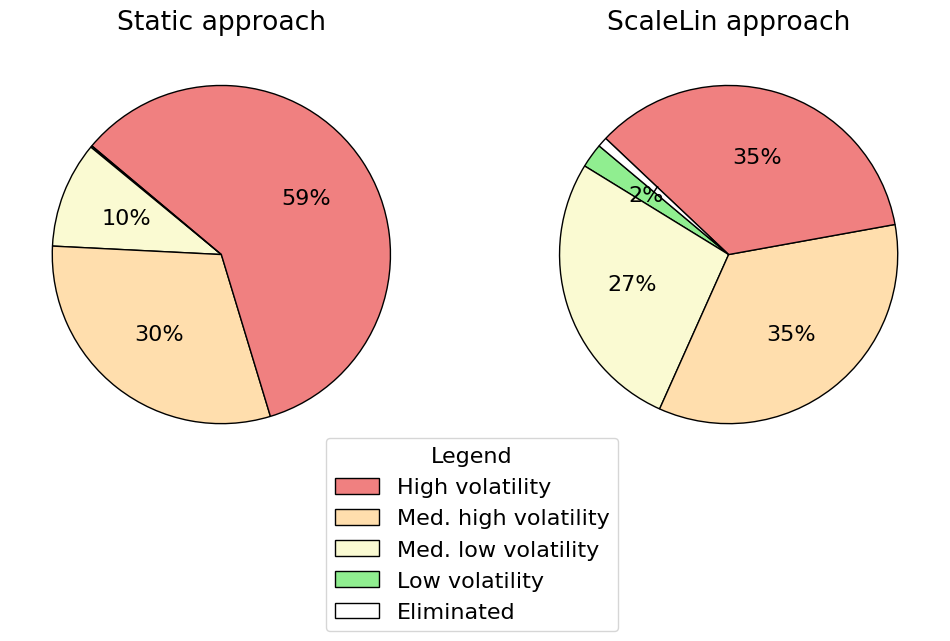

In [31]:
# Data for the pie charts
labels = [
    "Low volatility",
    "Med. low volatility",
    "Med. high volatility",
    "High volatility",
    "Eliminated",
]

# Data for each approach
sizes_constant = [
    0.08646907892623601,
    5.731308457579972,
    17.196331044073496,
    33.39801842895727,
    0,
]
sizes_scalelin = [
    1.3168414436659583,
    15.279346447298497,
    19.484760273610995,
    19.80420021464468,
    0.5269786303168473,
]

# Define colors for each category
colors = ["lightgreen", "lightgoldenrodyellow", "navajowhite", "lightcoral", "white"]


# Custom autopct function to hide zero or thin slice percentages
def custom_autopct(pct):
    return ("%1.0f%%" % pct) if pct > 1.5 else ""


# Initialize the figure and axes with specific size ratios
plt.rcParams["font.size"] = 16
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), gridspec_kw={"width_ratios": [1, 1]}
)

# Set wedge properties to add black edges to slices
wedgeprops = {"edgecolor": "black", "linewidth": 1}

# Plot the pie charts with custom autopct and wedgeprops
wedges1, texts1, autotexts1 = ax1.pie(
    sizes_constant,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
)
ax1.set_title("Static approach", pad=10)

wedges2, texts2, autotexts2 = ax2.pie(
    sizes_scalelin,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
)
ax2.set_title("ScaleLin approach", pad=10)

# Order for the legend
legend_order = [
    "High volatility",
    "Med. high volatility",
    "Med. low volatility",
    "Low volatility",
    "Eliminated",
]

# Create the legend in the desired order by using wedges from wedges1 in the new order
ordered_wedges = [wedges1[3], wedges1[2], wedges1[1], wedges1[0], wedges1[4]]

# Add a vertical legend below the pie charts
legend = fig.legend(
    ordered_wedges,
    legend_order,
    loc="upper center",
    bbox_to_anchor=(0.51, 0.35),
    ncol=1,
    title="Legend",
)

# Adjust the spacing between the plots and the legend
plt.subplots_adjust(bottom=0.25)

# Adjust layout and save the figure
plt.savefig(
    "figures/piecharts-8.png",
    format="png",
    dpi=400,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

### Input for Figure 10 and Table 3


In [17]:
# Step 1: Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_stepfloor = pd.read_csv(
    "results/Calculating p2 using stepfloor heuristic m is 2 zeta is 1p35 - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Step 2: Define constants
sigma_bar = 0.03330250038960859
xi_l = 0.75
xi_u = 1.25

# Step 3: Calculate the total sum of the 'p2' and 'r_Lin' column values for the 2 datasets
sum_p2_constant = np.nansum(df_constant["p2"])
sum_p2_stepfloor = np.nansum(df_stepfloor["p2"])

sum_rN_constant = np.nansum(df_constant["r_Lin"])
sum_rN_stepfloor = np.nansum(df_stepfloor["r_Lin"])

print(f"Step 3:")
print(f"Total sum of 'p2' values (Constant): {sum_p2_constant}")
print(f"Total sum of 'p2' values (StepFloor): {sum_p2_stepfloor}")
print(f"Total sum of 'r_Lin' values (Constant): {sum_rN_constant}")
print(f"Total sum of 'r_Lin' values (StepFloor): {sum_rN_stepfloor}")

# Step 4: Divide rows into 4 groups based on 'sigma_i' values
sigma_i = df_constant[
    "sigma_i"
]  # Assuming 'sigma_i' is identical across all dataframes

group1 = df_constant[sigma_i <= xi_l * sigma_bar]
group2 = df_constant[(sigma_i > xi_l * sigma_bar) & (sigma_i <= sigma_bar)]
group3 = df_constant[(sigma_i > sigma_bar) & (sigma_i <= xi_u * sigma_bar)]
group4 = df_constant[sigma_i > xi_u * sigma_bar]

# Print the number of rows in each group
print(f"\nStep 4:")
print(f"Group 1: {len(group1)} rows")
print(f"Group 2: {len(group2)} rows")
print(f"Group 3: {len(group3)} rows")
print(f"Group 4: {len(group4)} rows")

# Step 5: Calculate the sum of 'p2' and 'r_Lin' values for the 4 groups in each dataset
group1_sum_constant_p2 = np.nansum(group1["p2"])
group2_sum_constant_p2 = np.nansum(group2["p2"])
group3_sum_constant_p2 = np.nansum(group3["p2"])
group4_sum_constant_p2 = np.nansum(group4["p2"])

group1_sum_constant_rN = np.nansum(group1["r_Lin"])
group2_sum_constant_rN = np.nansum(group2["r_Lin"])
group3_sum_constant_rN = np.nansum(group3["r_Lin"])
group4_sum_constant_rN = np.nansum(group4["r_Lin"])

# Group sums for 'p2' and 'r_Lin' (stepfloor)
group1_sum_stepfloor_p2 = np.nansum(df_stepfloor.loc[group1.index, "p2"])
group2_sum_stepfloor_p2 = np.nansum(df_stepfloor.loc[group2.index, "p2"])
group3_sum_stepfloor_p2 = np.nansum(df_stepfloor.loc[group3.index, "p2"])
group4_sum_stepfloor_p2 = np.nansum(df_stepfloor.loc[group4.index, "p2"])

group1_sum_stepfloor_rN = np.nansum(df_stepfloor.loc[group1.index, "r_Lin"])
group2_sum_stepfloor_rN = np.nansum(df_stepfloor.loc[group2.index, "r_Lin"])
group3_sum_stepfloor_rN = np.nansum(df_stepfloor.loc[group3.index, "r_Lin"])
group4_sum_stepfloor_rN = np.nansum(df_stepfloor.loc[group4.index, "r_Lin"])

# Step 6: Print the group sums for each heuristic
print(f"\nStep 6: Group sums")
# Constant heuristic
print("\nConstant:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_constant_p2}")
print(f"    Group 2 sum: {group2_sum_constant_p2}")
print(f"    Group 3 sum: {group3_sum_constant_p2}")
print(f"    Group 4 sum: {group4_sum_constant_p2}")
constant_p2_total = (
    group1_sum_constant_p2
    + group2_sum_constant_p2
    + group3_sum_constant_p2
    + group4_sum_constant_p2
)
print(f"  Subtotal (p2): {constant_p2_total}")

# Directly copy values
print(f"{group1_sum_constant_p2},")
print(f"{group2_sum_constant_p2},")
print(f"{group3_sum_constant_p2},")
print(f"{group4_sum_constant_p2},")


print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_constant_rN}")
print(f"    Group 2 sum: {group2_sum_constant_rN}")
print(f"    Group 3 sum: {group3_sum_constant_rN}")
print(f"    Group 4 sum: {group4_sum_constant_rN}")
constant_rN_total = (
    group1_sum_constant_rN
    + group2_sum_constant_rN
    + group3_sum_constant_rN
    + group4_sum_constant_rN
)
print(f"  Subtotal (r_Lin): {constant_rN_total}")

# Stepfloor heuristic
print("\nStepFloor:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_stepfloor_p2}")
print(f"    Group 2 sum: {group2_sum_stepfloor_p2}")
print(f"    Group 3 sum: {group3_sum_stepfloor_p2}")
print(f"    Group 4 sum: {group4_sum_stepfloor_p2}")
stepfloor_p2_total = (
    group1_sum_stepfloor_p2
    + group2_sum_stepfloor_p2
    + group3_sum_stepfloor_p2
    + group4_sum_stepfloor_p2
)
print(f"  Subtotal (p2): {stepfloor_p2_total}")
print(
    f"  Difference from Constant p2 subtotal: {stepfloor_p2_total - constant_p2_total}"
)

# Directly copy values
print(f"{group1_sum_stepfloor_p2},")
print(f"{group2_sum_stepfloor_p2},")
print(f"{group3_sum_stepfloor_p2},")
print(f"{group4_sum_stepfloor_p2},")
print(f"{constant_p2_total - stepfloor_p2_total}")


print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_stepfloor_rN}")
print(f"    Group 2 sum: {group2_sum_stepfloor_rN}")
print(f"    Group 3 sum: {group3_sum_stepfloor_rN}")
print(f"    Group 4 sum: {group4_sum_stepfloor_rN}")
stepfloor_rN_total = (
    group1_sum_stepfloor_rN
    + group2_sum_stepfloor_rN
    + group3_sum_stepfloor_rN
    + group4_sum_stepfloor_rN
)
print(f"  Subtotal (r_Lin): {stepfloor_rN_total}")
print(
    f"  Difference from Constant r_Lin subtotal: {stepfloor_rN_total - constant_rN_total}"
)


# Step 7: Calculate ratios for each group
def calculate_ratio(stepfloor_sum, constant_sum):
    return stepfloor_sum / constant_sum - 1 if constant_sum != 0 else np.nan


def calculate_ratio_rN(stepfloor_sum, constant_sum):
    return stepfloor_sum / constant_sum - 1 if constant_sum != 0 else np.nan


# Total ratios
total_ratio_stepfloor = calculate_ratio(sum_p2_stepfloor, sum_p2_constant)

total_rN_ratio_stepfloor = calculate_ratio_rN(sum_rN_stepfloor, sum_rN_constant)

# Group ratios
group1_ratio_stepfloor = calculate_ratio(
    group1_sum_stepfloor_p2, group1_sum_constant_p2
)
group1_rN_ratio_stepfloor = calculate_ratio_rN(
    group1_sum_stepfloor_rN, group1_sum_constant_rN
)

group2_ratio_stepfloor = calculate_ratio(
    group2_sum_stepfloor_p2, group2_sum_constant_p2
)
group2_rN_ratio_stepfloor = calculate_ratio_rN(
    group2_sum_stepfloor_rN, group2_sum_constant_rN
)

group3_ratio_stepfloor = calculate_ratio(
    group3_sum_stepfloor_p2, group3_sum_constant_p2
)
group3_rN_ratio_stepfloor = calculate_ratio_rN(
    group3_sum_stepfloor_rN, group3_sum_constant_rN
)

group4_ratio_stepfloor = calculate_ratio(
    group4_sum_stepfloor_p2, group4_sum_constant_p2
)
group4_rN_ratio_stepfloor = calculate_ratio_rN(
    group4_sum_stepfloor_rN, group4_sum_constant_rN
)

# Step 8: Print ratios for each group
print(f"\nStep 8: Group ratios")
print("\nRatios (StepFloor/Constant):")
print(f"  Group 1 p2 ratio: {group1_ratio_stepfloor}")
print(f"  Group 1 rN ratio: {group1_rN_ratio_stepfloor}")

print(f"  Group 2 p2 ratio: {group2_ratio_stepfloor}")
print(f"  Group 2 rN ratio: {group2_rN_ratio_stepfloor}")

print(f"  Group 3 p2 ratio: {group3_ratio_stepfloor}")
print(f"  Group 3 rN ratio: {group3_rN_ratio_stepfloor}")

print(f"  Group 4 p2 ratio: {group4_ratio_stepfloor}")
print(f"  Group 4 rN ratio: {group4_rN_ratio_stepfloor}")

print(f"\nTotal p2 ratio (StepFloor/Constant): {total_ratio_stepfloor}")
print(f"Total rN ratio (StepFloor/Constant): {total_rN_ratio_stepfloor}")

# Step 6: Calculate percentage changes for 'p2'
group1_stepfloor_percentage_change_p2 = (
    (group1_sum_stepfloor_p2 - group1_sum_constant_p2) / group1_sum_constant_p2 * 100
)
group2_stepfloor_percentage_change_p2 = (
    (group2_sum_stepfloor_p2 - group2_sum_constant_p2) / group2_sum_constant_p2 * 100
)
group3_stepfloor_percentage_change_p2 = (
    (group3_sum_stepfloor_p2 - group3_sum_constant_p2) / group3_sum_constant_p2 * 100
)
group4_stepfloor_percentage_change_p2 = (
    (group4_sum_stepfloor_p2 - group4_sum_constant_p2) / group4_sum_constant_p2 * 100
)
total_stepfloor_percentage_change_p2 = (
    (sum_p2_stepfloor - sum_p2_constant) / sum_p2_constant * 100
)

# Step 7: Calculate percentage changes for 'r_Lin'
group1_stepfloor_percentage_change_rN = (
    (group1_sum_stepfloor_rN - group1_sum_constant_rN) / group1_sum_constant_rN * 100
)
group2_stepfloor_percentage_change_rN = (
    (group2_sum_stepfloor_rN - group2_sum_constant_rN) / group2_sum_constant_rN * 100
)
group3_stepfloor_percentage_change_rN = (
    (group3_sum_stepfloor_rN - group3_sum_constant_rN) / group3_sum_constant_rN * 100
)
group4_stepfloor_percentage_change_rN = (
    (group4_sum_stepfloor_rN - group4_sum_constant_rN) / group4_sum_constant_rN * 100
)
total_stepfloor_percentage_change_rN = (
    (sum_rN_stepfloor - sum_rN_constant) / sum_rN_constant * 100
)

# Step 8: Print the percentage changes for 'p2'
print("\nPercentage changes (StepFloor - Constant) / Constant for 'p2':")
print(f"Group 4: {group4_stepfloor_percentage_change_p2:.0f}%")
print(f"Group 3: {group3_stepfloor_percentage_change_p2:.0f}%")
print(f"Group 2: {group2_stepfloor_percentage_change_p2:.0f}%")
print(f"Group 1: {group1_stepfloor_percentage_change_p2:.0f}%")
print(f"Total: {total_stepfloor_percentage_change_p2:.0f}%")

# Step 9: Print the percentage changes for 'r_Lin'
print("\nPercentage changes (StepFloor - Constant) / Constant for 'r_Lin':")
print(f"Group 4: {group4_stepfloor_percentage_change_rN:.0f}%")
print(f"Group 3: {group3_stepfloor_percentage_change_rN:.0f}%")
print(f"Group 2: {group2_stepfloor_percentage_change_rN:.0f}%")
print(f"Group 1: {group1_stepfloor_percentage_change_rN:.0f}%")
print(f"Total: {total_stepfloor_percentage_change_rN:.0f}%")

Step 3:
Total sum of 'p2' values (Constant): 56.41212700953699
Total sum of 'p2' values (StepFloor): 36.159580990341695
Total sum of 'r_Lin' values (Constant): 5255.999999999999
Total sum of 'r_Lin' values (StepFloor): 5696.999999999998

Step 4:
Group 1: 983 rows
Group 2: 4118 rows
Group 3: 2510 rows
Group 4: 1149 rows

Step 6: Group sums

Constant:
  p2:
    Group 1 sum: 0.08646907892623601
    Group 2 sum: 5.731308457579974
    Group 3 sum: 17.196331044073496
    Group 4 sum: 33.39801842895727
  Subtotal (p2): 56.412127009536974
0.08646907892623601,
5.731308457579974,
17.196331044073496,
33.39801842895727,
  r_Lin:
    Group 1 sum: 589.8
    Group 2 sum: 2470.7999999999993
    Group 3 sum: 1506.0
    Group 4 sum: 689.4000000000001
  Subtotal (r_Lin): 5256.0

StepFloor:
  p2:
    Group 1 sum: 0.08646907892623616
    Group 2 sum: 5.731308457579981
    Group 3 sum: 17.196331044073514
    Group 4 sum: 13.145472409761968
  Subtotal (p2): 36.159580990341695
  Difference from Constant p2 su

### Create Figure 10 with pie charts of StepFloor vs Static


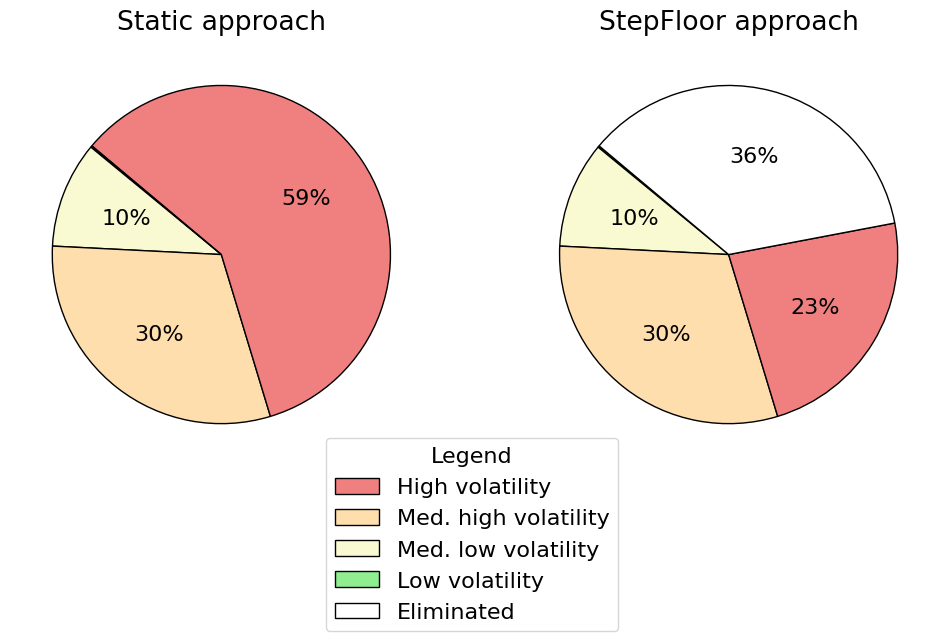

In [29]:
# Data for the pie charts
labels = [
    "Low volatility",
    "Med. low volatility",
    "Med. high volatility",
    "High volatility",
    "Eliminated",
]

# Data for each approach
sizes_constant = [
    0.08646907892623601,
    5.731308457579972,
    17.196331044073496,
    33.39801842895727,
    0,
]
sizes_stepfloor = [
    0.08646907892623616,
    5.7313084575799795,
    17.19633104407351,
    13.145472409761966,
    20.25254601919528,
]

# Define colors for each category
colors = ["lightgreen", "lightgoldenrodyellow", "navajowhite", "lightcoral", "white"]


# Custom autopct function to hide zero or thin slice percentages
def custom_autopct(pct):
    return ("%1.0f%%" % pct) if pct > 0.5 else ""


# Initialize the figure and axes with specific size ratios
plt.rcParams["font.size"] = 16
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 8), gridspec_kw={"width_ratios": [1, 1]}
)

# Set wedge properties to add black edges to slices
wedgeprops = {"edgecolor": "black", "linewidth": 1}

# Plot the pie charts with custom autopct and wedgeprops
wedges1, texts1, autotexts1 = ax1.pie(
    sizes_constant,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
)
ax1.set_title("Static approach", pad=10)

wedges2, texts2, autotexts2 = ax2.pie(
    sizes_stepfloor,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
)
ax2.set_title("StepFloor approach", pad=10)

# Order for the legend
legend_order = [
    "High volatility",
    "Med. high volatility",
    "Med. low volatility",
    "Low volatility",
    "Eliminated",
]

# Create the legend in the desired order by using wedges from wedges1 in the new order
ordered_wedges = [wedges1[3], wedges1[2], wedges1[1], wedges1[0], wedges1[4]]

# Add a vertical legend below the pie charts
legend = fig.legend(
    ordered_wedges,
    legend_order,
    loc="upper center",
    bbox_to_anchor=(0.51, 0.35),
    ncol=1,
    title="Legend",
)

# Adjust the spacing between the plots and the legend
plt.subplots_adjust(bottom=0.25)

# Adjust layout and save the figure
plt.savefig(
    "figures/piecharts-10.png",
    format="png",
    dpi=400,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

### Input for Figure 6 and Table 1


In [19]:
# Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_linear = pd.read_csv(
    "results/Calculating p2 using linear heuristic - F_rec sigma bar 0.0333 beta 0.863.csv"
)
df_step = pd.read_csv(
    "results/Calculating p2 using step heuristic - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Step 1: Define constants
sigma_bar = 0.03330250038960859
xi_l = 0.75
xi_u = 1.25

# Step 2: Calculate the total sum of the 'p2' and 'r_Lin' column values for the 3 datasets
sum_p2_constant = np.nansum(df_constant["p2"])
sum_p2_linear = np.nansum(df_linear["p2"])
sum_p2_step = np.nansum(df_step["p2"])

sum_rN_constant = np.nansum(df_constant["r_Lin"])
sum_rN_linear = np.nansum(df_linear["r_Lin"])
sum_rN_step = np.nansum(df_step["r_Lin"])

print(f"Total sum of 'p2' values (Constant): {sum_p2_constant}")
print(f"Total sum of 'p2' values (Linear): {sum_p2_linear}")
print(f"Total sum of 'p2' values (Step): {sum_p2_step}")
print(f"Total sum of 'r_Lin' values (Constant): {sum_rN_constant}")
print(f"Total sum of 'r_Lin' values (Linear): {sum_rN_linear}")
print(f"Total sum of 'r_Lin' values (Step): {sum_rN_step}")

# Step 3: Divide rows into 4 groups based on 'sigma_i' values
sigma_i = df_constant[
    "sigma_i"
]  # Assuming 'sigma_i' is identical across all dataframes

group1 = df_constant[sigma_i <= xi_l * sigma_bar]
group2 = df_constant[(sigma_i > xi_l * sigma_bar) & (sigma_i <= sigma_bar)]
group3 = df_constant[(sigma_i > sigma_bar) & (sigma_i <= xi_u * sigma_bar)]
group4 = df_constant[sigma_i > xi_u * sigma_bar]

# Print the number of rows in each group
print(f"Group 1: {len(group1)} rows")
print(f"Group 2: {len(group2)} rows")
print(f"Group 3: {len(group3)} rows")
print(f"Group 4: {len(group4)} rows")

# Step 4: Calculate the sum of 'p2' and 'r_Lin' values for the 4 groups in each dataset
# Group sums for 'p2' and 'r_Lin' (constant)
group1_sum_constant_p2 = np.nansum(group1["p2"])
group2_sum_constant_p2 = np.nansum(group2["p2"])
group3_sum_constant_p2 = np.nansum(group3["p2"])
group4_sum_constant_p2 = np.nansum(group4["p2"])

group1_sum_constant_rN = np.nansum(group1["r_Lin"])
group2_sum_constant_rN = np.nansum(group2["r_Lin"])
group3_sum_constant_rN = np.nansum(group3["r_Lin"])
group4_sum_constant_rN = np.nansum(group4["r_Lin"])

# Group sums for 'p2' and 'r_Lin' (linear)
group1_sum_linear_p2 = np.nansum(df_linear.loc[group1.index, "p2"])
group2_sum_linear_p2 = np.nansum(df_linear.loc[group2.index, "p2"])
group3_sum_linear_p2 = np.nansum(df_linear.loc[group3.index, "p2"])
group4_sum_linear_p2 = np.nansum(df_linear.loc[group4.index, "p2"])

group1_sum_linear_rN = np.nansum(df_linear.loc[group1.index, "r_Lin"])
group2_sum_linear_rN = np.nansum(df_linear.loc[group2.index, "r_Lin"])
group3_sum_linear_rN = np.nansum(df_linear.loc[group3.index, "r_Lin"])
group4_sum_linear_rN = np.nansum(df_linear.loc[group4.index, "r_Lin"])

# Group sums for 'p2' and 'r_Lin' (step)
group1_sum_step_p2 = np.nansum(df_step.loc[group1.index, "p2"])
group2_sum_step_p2 = np.nansum(df_step.loc[group2.index, "p2"])
group3_sum_step_p2 = np.nansum(df_step.loc[group3.index, "p2"])
group4_sum_step_p2 = np.nansum(df_step.loc[group4.index, "p2"])

group1_sum_step_rN = np.nansum(df_step.loc[group1.index, "r_Lin"])
group2_sum_step_rN = np.nansum(df_step.loc[group2.index, "r_Lin"])
group3_sum_step_rN = np.nansum(df_step.loc[group3.index, "r_Lin"])
group4_sum_step_rN = np.nansum(df_step.loc[group4.index, "r_Lin"])

# Print the group sums to check they add up to the total sum
print("\nGroup sums:")

# Constant heuristic
print("\nConstant:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_constant_p2}")
print(f"    Group 2 sum: {group2_sum_constant_p2}")
print(f"    Group 3 sum: {group3_sum_constant_p2}")
print(f"    Group 4 sum: {group4_sum_constant_p2}")
constant_p2_total = (
    group1_sum_constant_p2
    + group2_sum_constant_p2
    + group3_sum_constant_p2
    + group4_sum_constant_p2
)
print(f"  Subtotal (p2): {constant_p2_total}")

# values to directly copy
print(f"{group1_sum_constant_p2},")
print(f"{group2_sum_constant_p2},")
print(f"{group3_sum_constant_p2},")
print(f"{group4_sum_constant_p2},")


# rLin
print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_constant_rN}")
print(f"    Group 2 sum: {group2_sum_constant_rN}")
print(f"    Group 3 sum: {group3_sum_constant_rN}")
print(f"    Group 4 sum: {group4_sum_constant_rN}")
constant_rN_total = (
    group1_sum_constant_rN
    + group2_sum_constant_rN
    + group3_sum_constant_rN
    + group4_sum_constant_rN
)
print(f"  Subtotal (r_Lin): {constant_rN_total}")

# Linear heuristic
print("\nLinear:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_linear_p2}")
print(f"    Group 2 sum: {group2_sum_linear_p2}")
print(f"    Group 3 sum: {group3_sum_linear_p2}")
print(f"    Group 4 sum: {group4_sum_linear_p2}")
linear_p2_total = (
    group1_sum_linear_p2
    + group2_sum_linear_p2
    + group3_sum_linear_p2
    + group4_sum_linear_p2
)
print(f"  Subtotal (p2): {linear_p2_total}")
print(f"  Difference from Constant p2 subtotal: {linear_p2_total - constant_p2_total}")

# values to directly copy
print(f"{group1_sum_linear_p2},")
print(f"{group2_sum_linear_p2},")
print(f"{group3_sum_linear_p2},")
print(f"{group4_sum_linear_p2},")
print(f"{constant_p2_total - linear_p2_total}")


# rLin
print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_linear_rN}")
print(f"    Group 2 sum: {group2_sum_linear_rN}")
print(f"    Group 3 sum: {group3_sum_linear_rN}")
print(f"    Group 4 sum: {group4_sum_linear_rN}")
linear_rN_total = (
    group1_sum_linear_rN
    + group2_sum_linear_rN
    + group3_sum_linear_rN
    + group4_sum_linear_rN
)
print(f"  Subtotal (r_Lin): {linear_rN_total}")
print(
    f"  Difference from Constant r_Lin subtotal: {linear_rN_total - constant_rN_total}"
)

# Step heuristic
print("\nStep:")
print("  p2:")
print(f"    Group 1 sum: {group1_sum_step_p2}")
print(f"    Group 2 sum: {group2_sum_step_p2}")
print(f"    Group 3 sum: {group3_sum_step_p2}")
print(f"    Group 4 sum: {group4_sum_step_p2}")
step_p2_total = (
    group1_sum_step_p2 + group2_sum_step_p2 + group3_sum_step_p2 + group4_sum_step_p2
)
print(f"  Subtotal (p2): {step_p2_total}")
print(f"  Difference from Constant p2 subtotal: {step_p2_total - constant_p2_total}")

# values to directly copy
print(f"{group1_sum_step_p2},")
print(f"{group2_sum_step_p2},")
print(f"{group3_sum_step_p2},")
print(f"{group4_sum_step_p2},")
print(f"{constant_p2_total - step_p2_total}")


# rLin
print("  r_Lin:")
print(f"    Group 1 sum: {group1_sum_step_rN}")
print(f"    Group 2 sum: {group2_sum_step_rN}")
print(f"    Group 3 sum: {group3_sum_step_rN}")
print(f"    Group 4 sum: {group4_sum_step_rN}")
step_rN_total = (
    group1_sum_step_rN + group2_sum_step_rN + group3_sum_step_rN + group4_sum_step_rN
)
print(f"  Subtotal (r_Lin): {step_rN_total}")
print(f"  Difference from Constant r_Lin subtotal: {step_rN_total - constant_rN_total}")


# Step 5: Calculate ratios for each group
def calculate_ratio(linear_sum, step_sum, constant_sum):
    p2_sum_ratio_linear = linear_sum / constant_sum if constant_sum != 0 else np.nan
    p2_sum_ratio_step = step_sum / constant_sum if constant_sum != 0 else np.nan
    return p2_sum_ratio_linear, p2_sum_ratio_step


def calculate_ratio_rN(linear_sum, step_sum, constant_sum):
    rN_sum_ratio_linear = linear_sum / constant_sum if constant_sum != 0 else np.nan
    rN_sum_ratio_step = step_sum / constant_sum if constant_sum != 0 else np.nan
    return rN_sum_ratio_linear, rN_sum_ratio_step


# Total ratios
total_ratio_linear, total_ratio_step = calculate_ratio(
    sum_p2_linear, sum_p2_step, sum_p2_constant
)

total_rN_ratio_linear, total_rN_ratio_step = calculate_ratio_rN(
    sum_rN_linear, sum_rN_step, sum_rN_constant
)

# Group ratios
group1_ratio_linear, group1_ratio_step = calculate_ratio(
    group1_sum_linear_p2, group1_sum_step_p2, group1_sum_constant_p2
)
group1_rN_ratio_linear, group1_rN_ratio_step = calculate_ratio_rN(
    group1_sum_linear_rN, group1_sum_step_rN, group1_sum_constant_rN
)

group2_ratio_linear, group2_ratio_step = calculate_ratio(
    group2_sum_linear_p2, group2_sum_step_p2, group2_sum_constant_p2
)
group2_rN_ratio_linear, group2_rN_ratio_step = calculate_ratio_rN(
    group2_sum_linear_rN, group2_sum_step_rN, group2_sum_constant_rN
)

group3_ratio_linear, group3_ratio_step = calculate_ratio(
    group3_sum_linear_p2, group3_sum_step_p2, group3_sum_constant_p2
)
group3_rN_ratio_linear, group3_rN_ratio_step = calculate_ratio_rN(
    group3_sum_linear_rN, group3_sum_step_rN, group3_sum_constant_rN
)

group4_ratio_linear, group4_ratio_step = calculate_ratio(
    group4_sum_linear_p2, group4_sum_step_p2, group4_sum_constant_p2
)
group4_rN_ratio_linear, group4_rN_ratio_step = calculate_ratio_rN(
    group4_sum_linear_rN, group4_sum_step_rN, group4_sum_constant_rN
)


# Step 7: Calculate percentage changes for each group and total
def calculate_percentage_change(linear_sum, constant_sum):
    return (
        ((linear_sum - constant_sum) / constant_sum) * 100
        if constant_sum != 0
        else np.nan
    )


def calculate_step_percentage_change(step_sum, constant_sum):
    return (
        ((step_sum - constant_sum) / constant_sum) * 100
        if constant_sum != 0
        else np.nan
    )


# Total percentage changes
total_linear_percentage_change = calculate_percentage_change(
    sum_p2_linear, sum_p2_constant
)
total_step_percentage_change = calculate_step_percentage_change(
    sum_p2_step, sum_p2_constant
)

# Group percentage changes
group1_linear_percentage_change = calculate_percentage_change(
    group1_sum_linear_p2, group1_sum_constant_p2
)
group1_step_percentage_change = calculate_step_percentage_change(
    group1_sum_step_p2, group1_sum_constant_p2
)

group2_linear_percentage_change = calculate_percentage_change(
    group2_sum_linear_p2, group2_sum_constant_p2
)
group2_step_percentage_change = calculate_step_percentage_change(
    group2_sum_step_p2, group2_sum_constant_p2
)

group3_linear_percentage_change = calculate_percentage_change(
    group3_sum_linear_p2, group3_sum_constant_p2
)
group3_step_percentage_change = calculate_step_percentage_change(
    group3_sum_step_p2, group3_sum_constant_p2
)

group4_linear_percentage_change = calculate_percentage_change(
    group4_sum_linear_p2, group4_sum_constant_p2
)
group4_step_percentage_change = calculate_step_percentage_change(
    group4_sum_step_p2, group4_sum_constant_p2
)

# Print the percentage changes
print("\nPercentage changes (Linear - Constant) / Constant for 'p2':")
print(f"Group 4: {group4_linear_percentage_change:.0f}%")
print(f"Group 3: {group3_linear_percentage_change:.0f}%")
print(f"Group 2: {group2_linear_percentage_change:.0f}%")
print(f"Group 1: {group1_linear_percentage_change:.0f}%")
print(f"Total: {total_linear_percentage_change:.0f}%")

print("\nPercentage changes (Step - Constant) / Constant for 'p2':")
print(f"Group 4: {group4_step_percentage_change:.0f}%")
print(f"Group 3: {group3_step_percentage_change:.0f}%")
print(f"Group 2: {group2_step_percentage_change:.0f}%")
print(f"Group 1: {group1_step_percentage_change:.0f}%")
print(f"Total: {total_step_percentage_change:.0f}%")


# Step 8: Calculate percentage changes for each group and total for 'r_Lin'
def calculate_percentage_change_rN(linear_sum, constant_sum):
    return (
        ((linear_sum - constant_sum) / constant_sum) * 100
        if constant_sum != 0
        else np.nan
    )


def calculate_step_percentage_change_rN(step_sum, constant_sum):
    return (
        ((step_sum - constant_sum) / constant_sum) * 100
        if constant_sum != 0
        else np.nan
    )


# Total percentage changes for 'r_Lin'
total_linear_percentage_change_rN = calculate_percentage_change_rN(
    sum_rN_linear, sum_rN_constant
)
total_step_percentage_change_rN = calculate_step_percentage_change_rN(
    sum_rN_step, sum_rN_constant
)

# Group percentage changes for 'r_Lin'
group1_linear_percentage_change_rN = calculate_percentage_change_rN(
    group1_sum_linear_rN, group1_sum_constant_rN
)
group1_step_percentage_change_rN = calculate_step_percentage_change_rN(
    group1_sum_step_rN, group1_sum_constant_rN
)

group2_linear_percentage_change_rN = calculate_percentage_change_rN(
    group2_sum_linear_rN, group2_sum_constant_rN
)
group2_step_percentage_change_rN = calculate_step_percentage_change_rN(
    group2_sum_step_rN, group2_sum_constant_rN
)

group3_linear_percentage_change_rN = calculate_percentage_change_rN(
    group3_sum_linear_rN, group3_sum_constant_rN
)
group3_step_percentage_change_rN = calculate_step_percentage_change_rN(
    group3_sum_step_rN, group3_sum_constant_rN
)

group4_linear_percentage_change_rN = calculate_percentage_change_rN(
    group4_sum_linear_rN, group4_sum_constant_rN
)
group4_step_percentage_change_rN = calculate_step_percentage_change_rN(
    group4_sum_step_rN, group4_sum_constant_rN
)

# Print the percentage changes for 'r_Lin'
print("\nPercentage changes (Linear - Constant) / Constant for 'r_Lin':")
print(f"Group 4: {group4_linear_percentage_change_rN:.0f}%")
print(f"Group 3: {group3_linear_percentage_change_rN:.0f}%")
print(f"Group 2: {group2_linear_percentage_change_rN:.0f}%")
print(f"Group 1: {group1_linear_percentage_change_rN:.0f}%")
print(f"Total: {total_linear_percentage_change_rN:.0f}%")

print("\nPercentage changes (Step - Constant) / Constant for 'r_Lin':")
print(f"Group 4: {group4_step_percentage_change_rN:.0f}%")
print(f"Group 3: {group3_step_percentage_change_rN:.0f}%")
print(f"Group 2: {group2_step_percentage_change_rN:.0f}%")
print(f"Group 1: {group1_step_percentage_change_rN:.0f}%")
print(f"Total: {total_step_percentage_change_rN:.0f}%")

Total sum of 'p2' values (Constant): 56.41212700953699
Total sum of 'p2' values (Linear): 35.419986649975264
Total sum of 'p2' values (Step): 41.77475500231001
Total sum of 'r_Lin' values (Constant): 5255.999999999999
Total sum of 'r_Lin' values (Linear): 5256.0
Total sum of 'r_Lin' values (Step): 5256.000000000001
Group 1: 983 rows
Group 2: 4118 rows
Group 3: 2510 rows
Group 4: 1149 rows

Group sums:

Constant:
  p2:
    Group 1 sum: 0.08646907892623601
    Group 2 sum: 5.731308457579974
    Group 3 sum: 17.196331044073496
    Group 4 sum: 33.39801842895727
  Subtotal (p2): 56.412127009536974
0.08646907892623601,
5.731308457579974,
17.196331044073496,
33.39801842895727,
  r_Lin:
    Group 1 sum: 589.8
    Group 2 sum: 2470.7999999999993
    Group 3 sum: 1506.0
    Group 4 sum: 689.4000000000001
  Subtotal (r_Lin): 5256.0

Linear:
  p2:
    Group 1 sum: 0.6517450149360777
    Group 2 sum: 8.696762017452443
    Group 3 sum: 12.213703745497302
    Group 4 sum: 13.85777587208944
  Subtota

### Create Figure 6


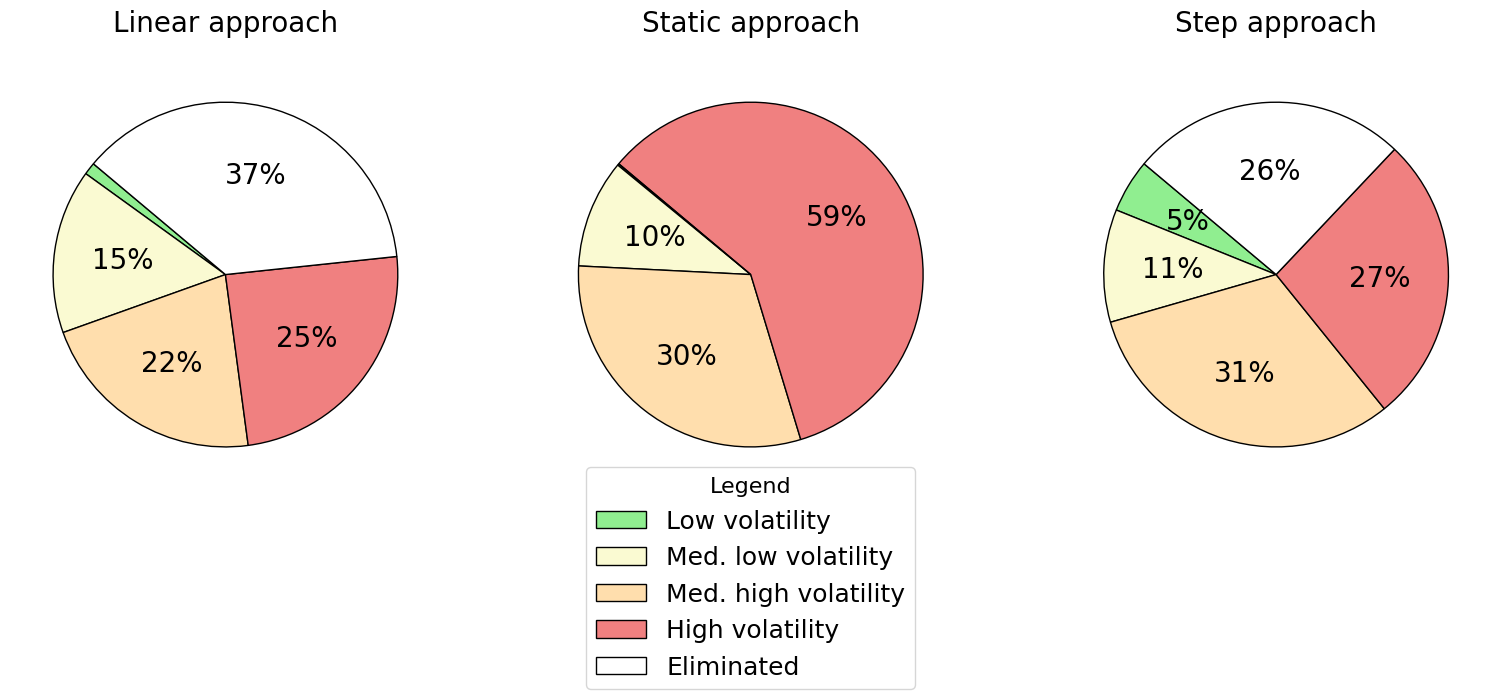

In [30]:
# Data for the pie charts
labels = [
    "Low volatility",
    "Med. low volatility",
    "Med. high volatility",
    "High volatility",
    "Eliminated",
]

# Data for each approach
sizes_linear = [
    0.6517450149360777,
    8.696762017452443,
    12.213703745497297,
    13.857775872089439,
    20.992140359561716,
]
sizes_constant = [
    0.08646907892623601,
    5.731308457579972,
    17.196331044073496,
    33.39801842895727,
    0,
]
sizes_step = [
    2.820919912788464,
    5.963860304352455,
    17.681198883486196,
    15.308775901682889,
    14.637372007226972,
]

# Define colors for each category
colors = ["lightgreen", "lightgoldenrodyellow", "navajowhite", "lightcoral", "white"]


# Custom autopct function to hide zero or thin slice percentages
def custom_autopct(pct):
    return ("%1.0f%%" % pct) if pct > 1.5 else ""


# Initialize the figure and axes with specific size ratios
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(16, 6), gridspec_kw={"width_ratios": [1, 1, 1]}
)

# Set wedge properties to add black edges to slices
wedgeprops = {"edgecolor": "black", "linewidth": 1}

# Plot the pie charts
ax1.pie(
    sizes_linear,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
    textprops={"fontsize": 20},  # Set fontsize for pie slice labels
)
ax1.set_title("Linear approach", pad=20, fontsize=20)  # Set fontsize for title

ax2.pie(
    sizes_constant,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
    textprops={"fontsize": 20},  # Set fontsize for pie slice labels
)
ax2.set_title("Static approach", pad=20, fontsize=20)  # Set fontsize for title

ax3.pie(
    sizes_step,
    colors=colors,
    autopct=custom_autopct,
    startangle=140,
    wedgeprops=wedgeprops,
    textprops={"fontsize": 20},  # Set fontsize for pie slice labels
)
ax3.set_title("Step approach", pad=20, fontsize=20)  # Set fontsize for title

# Add a vertical legend below the pie charts
fig.legend(
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.3),
    ncol=1,
    title="Legend",
    fontsize=18,
)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.2, 1, 1])  # Adjust bottom margin to fit legend
plt.savefig(
    "figures/piecharts-4.png",
    format="png",
    dpi=400,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

### Create Figure 5


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sum of r_Lin (Constant r_LinProv): 5255.999999999999
Sum of r_Lin (Linear Heuristic): 5256.0
Sum of r_Lin (Step Heuristic): 5256.000000000001
Average r_Lin (Constant r_LinProv): 0.5999999999999999
Average r_Lin (Linear Heuristic): 0.6
Average r_Lin (Step Heuristic): 0.6000000000000001
Standard Deviation of r_Lin (Constant r_LinProv): 2.220446049250313e-16
Standard Deviation of r_Lin (Linear Heuristic): 0.15023946125395318
Standard Deviation of r_Lin (Step Heuristic): 0.1465030466197595
Number of NaN values (Constant r_LinProv): 0
Number of NaN values (Linear Heuristic): 0
Number of NaN values (Step Heuristic): 0


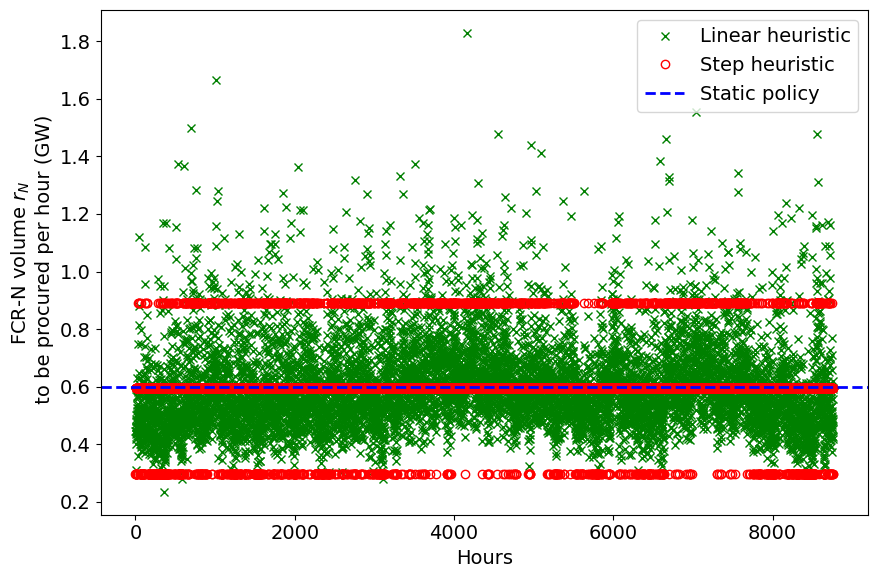

In [26]:
# Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_linear = pd.read_csv(
    "results/Calculating p2 using linear heuristic - F_rec sigma bar 0.0333 beta 0.863.csv"
)
df_step = pd.read_csv(
    "results/Calculating p2 using step heuristic - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Extract the 'r_Lin' column values and rename them
rN_constant = df_constant["r_Lin"].values
rN_linear = df_linear["r_Lin"].values
rN_step = df_step["r_Lin"].values

# Calculate the sum of 'r_Lin' for all cases
sum_rN_constant = np.nansum(rN_constant)  # Use np.nansum to ignore NaN values
sum_rN_linear = np.nansum(rN_linear)  # Use np.nansum to ignore NaN values
sum_rN_step = np.nansum(rN_step)  # Use np.nansum to ignore NaN values

print(f"Sum of r_Lin (Constant r_LinProv): {sum_rN_constant}")
print(f"Sum of r_Lin (Linear Heuristic): {sum_rN_linear}")
print(f"Sum of r_Lin (Step Heuristic): {sum_rN_step}")

# Calculate the average value of 'r_Lin' for all cases
average_rN_constant = np.nanmean(rN_constant)  # Use np.nanmean to ignore NaN values
average_rN_linear = np.nanmean(rN_linear)  # Use np.nanmean to ignore NaN values
average_rN_step = np.nanmean(rN_step)  # Use np.nanmean to ignore NaN values

print(f"Average r_Lin (Constant r_LinProv): {average_rN_constant}")
print(f"Average r_Lin (Linear Heuristic): {average_rN_linear}")
print(f"Average r_Lin (Step Heuristic): {average_rN_step}")

# Calculate the standard deviation of 'r_Lin' for all cases
std_rN_constant = np.nanstd(rN_constant)  # Use np.nanstd to ignore NaN values
std_rN_linear = np.nanstd(rN_linear)  # Use np.nanstd to ignore NaN values
std_rN_step = np.nanstd(rN_step)  # Use np.nanstd to ignore NaN values

print(f"Standard Deviation of r_Lin (Constant r_LinProv): {std_rN_constant}")
print(f"Standard Deviation of r_Lin (Linear Heuristic): {std_rN_linear}")
print(f"Standard Deviation of r_Lin (Step Heuristic): {std_rN_step}")

# Count the number of NaN values in the 'r_Lin' column for all cases
nan_count_constant = np.isnan(rN_constant).sum()
nan_count_linear = np.isnan(rN_linear).sum()
nan_count_step = np.isnan(rN_step).sum()

print(f"Number of NaN values (Constant r_LinProv): {nan_count_constant}")
print(f"Number of NaN values (Linear Heuristic): {nan_count_linear}")
print(f"Number of NaN values (Step Heuristic): {nan_count_step}")

# Create a plot
plt.rcParams["font.size"] = 14  # changes font size
plt.figure(figsize=(9, 6))

# Change the order of plotting and exclude lines
plt.plot(
    rN_linear,
    label="Linear heuristic",
    linestyle="None",
    marker="x",
    color="green",
    markersize=6,
)
plt.plot(
    rN_step,
    label="Step heuristic",
    linestyle="None",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="red",
    markersize=6,
)
# plt.plot(
#   rN_constant,
#  label="Static",
# linestyle="None",
# marker="o",
# color="blue",
# markersize=4,
# )

plt.axhline(y=0.6, color="b", linestyle="--", label="Static policy", linewidth=2)

# Add labels and legend
plt.xlabel("Hours")
plt.ylabel("FCR-N volume $r_N$ \n to be procured per hour (GW)")
plt.legend()
plt.tight_layout()
plt.savefig(
    "figures/r_N_plot_static_step_lin_F_ori_sigma_bar_0p0333_beta_0p863.eps",
    format="eps",
    dpi=400,
    bbox_inches="tight",
    transparent=True,
)
plt.show()

### Create Figure 7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sum of r_Lin (Constant r_LinProv): 5255.999999999999
Sum of r_Lin (ScaleLin Heuristic): 4520.16
Average r_Lin (Constant r_LinProv): 0.5999999999999999
Average r_Lin (ScaleLin Heuristic): 0.516
Standard Deviation of r_Lin (Constant r_LinProv): 2.220446049250313e-16
Standard Deviation of r_Lin (ScaleLin Heuristic): 0.12920593667839972
Number of NaN values (Constant r_LinProv): 0
Number of NaN values (ScaleLin Heuristic): 0


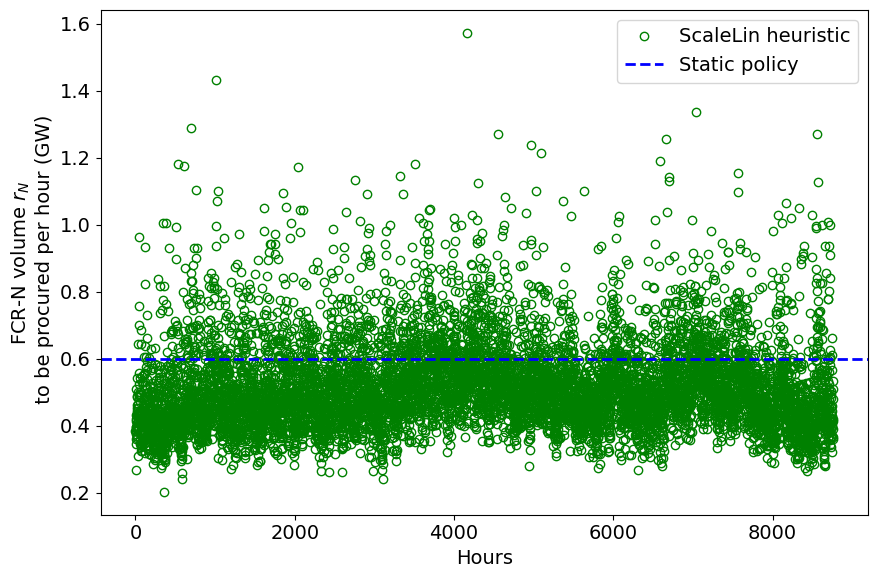

In [27]:
# Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_linear = pd.read_csv(
    "results/Calculating p2 using linear heuristic scaled DOWN - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Extract the 'r_Lin' column values and rename them
rN_constant = df_constant["r_Lin"].values
rN_linear = df_linear["r_Lin"].values

# Calculate the sum of 'r_Lin' for all cases
sum_rN_constant = np.nansum(rN_constant)  # Use np.nansum to ignore NaN values
sum_rN_linear = np.nansum(rN_linear)  # Use np.nansum to ignore NaN values

print(f"Sum of r_Lin (Constant r_LinProv): {sum_rN_constant}")
print(f"Sum of r_Lin (ScaleLin Heuristic): {sum_rN_linear}")

# Calculate the average value of 'r_Lin' for all cases
average_rN_constant = np.nanmean(rN_constant)  # Use np.nanmean to ignore NaN values
average_rN_linear = np.nanmean(rN_linear)  # Use np.nanmean to ignore NaN values

print(f"Average r_Lin (Constant r_LinProv): {average_rN_constant}")
print(f"Average r_Lin (ScaleLin Heuristic): {average_rN_linear}")

# Calculate the standard deviation of 'r_Lin' for all cases
std_rN_constant = np.nanstd(rN_constant)  # Use np.nanstd to ignore NaN values
std_rN_linear = np.nanstd(rN_linear)  # Use np.nanstd to ignore NaN values

print(f"Standard Deviation of r_Lin (Constant r_LinProv): {std_rN_constant}")
print(f"Standard Deviation of r_Lin (ScaleLin Heuristic): {std_rN_linear}")

# Count the number of NaN values in the 'r_Lin' column for all cases
nan_count_constant = np.isnan(rN_constant).sum()
nan_count_linear = np.isnan(rN_linear).sum()

print(f"Number of NaN values (Constant r_LinProv): {nan_count_constant}")
print(f"Number of NaN values (ScaleLin Heuristic): {nan_count_linear}")

# Create a plot
plt.rcParams["font.size"] = 14  # changes font size
plt.figure(figsize=(9, 6))

# Change the order of plotting and exclude lines
plt.plot(
    rN_linear,
    label="ScaleLin heuristic",
    linestyle="None",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="green",
    markersize=6,
)

plt.axhline(y=0.6, color="b", linestyle="--", label="Static policy", linewidth=2)

# Add labels and legend
plt.xlabel("Hours")
plt.ylabel("FCR-N volume $r_N$ \n to be procured per hour (GW)")
plt.legend()
plt.tight_layout()
plt.savefig(
    "figures/r_N_plot_ScaleLin_0p86_Static_F_rec_sigma_bar_0p0333_beta_0p863.eps",
    format="eps",
    dpi=400,
    bbox_inches="tight",
)
plt.show()

### Create Figure 9 comparing StepFloor heuristic vs. static approach


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Sum of r_Lin (Constant r_LinProv): 5255.999999999999
Sum of r_Lin (StepFloor Heuristic): 5696.999999999998
Average r_Lin (Constant r_LinProv): 0.5999999999999999
Average r_Lin (StepFloor Heuristic): 0.6503424657534245
Standard Deviation of r_Lin (Constant r_LinProv): 2.220446049250313e-16
Standard Deviation of r_Lin (StepFloor Heuristic): 0.16634637234974517
Number of NaN values (Constant r_LinProv): 0
Number of NaN values (StepFloor Heuristic): 0


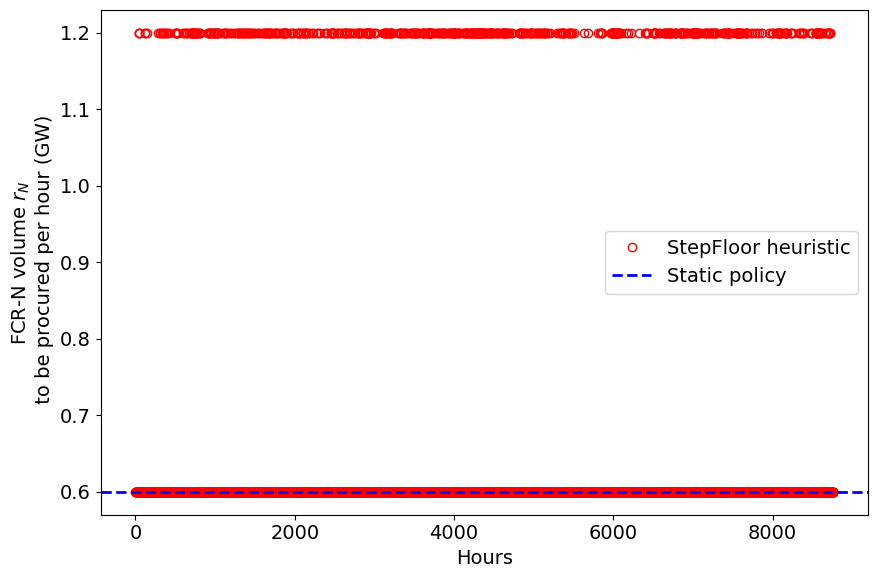

In [ ]:
# Read the CSV files
df_constant = pd.read_csv(
    "results/Calculating p2 using constant r_LinProv - F_rec sigma bar 0p0333 beta 0p863.csv"
)
df_step = pd.read_csv(
    "results/Calculating p2 using stepfloor heuristic m is 2 zeta is 1p35 - F_rec sigma bar 0p0333 beta 0p863.csv"
)

# Extract the 'r_Lin' column values and rename them
rN_constant = df_constant["r_Lin"].values
rN_step = df_step["r_Lin"].values

# Calculate the sum of 'r_Lin' for all cases
sum_rN_constant = np.nansum(rN_constant)  # Use np.nansum to ignore NaN values
sum_rN_step = np.nansum(rN_step)  # Use np.nansum to ignore NaN values

print(f"Sum of r_Lin (Constant r_LinProv): {sum_rN_constant}")
print(f"Sum of r_Lin (StepFloor Heuristic): {sum_rN_step}")

# Calculate the average value of 'r_Lin' for all cases
average_rN_constant = np.nanmean(rN_constant)  # Use np.nanmean to ignore NaN values
average_rN_step = np.nanmean(rN_step)  # Use np.nanmean to ignore NaN values

print(f"Average r_Lin (Constant r_LinProv): {average_rN_constant}")
print(f"Average r_Lin (StepFloor Heuristic): {average_rN_step}")

# Calculate the standard deviation of 'r_Lin' for all cases
std_rN_constant = np.nanstd(rN_constant)  # Use np.nanstd to ignore NaN values
std_rN_step = np.nanstd(rN_step)  # Use np.nanstd to ignore NaN values

print(f"Standard Deviation of r_Lin (Constant r_LinProv): {std_rN_constant}")
print(f"Standard Deviation of r_Lin (StepFloor Heuristic): {std_rN_step}")

# Count the number of NaN values in the 'r_Lin' column for all cases
nan_count_constant = np.isnan(rN_constant).sum()
nan_count_step = np.isnan(rN_step).sum()

print(f"Number of NaN values (Constant r_LinProv): {nan_count_constant}")
print(f"Number of NaN values (StepFloor Heuristic): {nan_count_step}")

# Create a plot
plt.rcParams["font.size"] = 14  # changes font size
plt.figure(figsize=(9, 6))

# Change the order of plotting and exclude lines
plt.plot(
    rN_step,
    label="StepFloor heuristic",
    linestyle="None",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="red",
    markersize=6,
)

plt.axhline(y=0.6, color="b", linestyle="--", label="Static policy", linewidth=2)

# Add labels and legend
plt.xlabel("Hours")
plt.ylabel("FCR-N volume $r_N$ \n to be procured per hour (GW)")
plt.legend()
plt.tight_layout()
plt.savefig(
    "figures/r_N_plot_const_StepFloor_zetais1p35_mis2_F_rec_sigma_bar_0p0333_beta_0p863.eps",
    format="eps",
    dpi=400,
    bbox_inches="tight",
)
plt.show()